# Test Inference for HED Model
---

In [18]:
# import torch libraries
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import os
import pylab
import numpy as np
import pandas as pd
from PIL import Image
import skimage.io as io
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch.nn as nn

# import the utility functions
from networks import HED
from datasets import BsdsDataset

from utils import Logger, AverageMeter, \
    load_checkpoint, save_checkpoint, load_vgg16_caffe, load_pretrained_caffe

In [19]:
# fix random seed
rng = np.random.RandomState(37148)

### Load Trained Model

In [20]:
device = torch.device('cuda')
# create instance of HED model
net = nn.DataParallel(HED(device))
net.cuda()

checkpoint = torch.load('../hed/data/hed_checkpoint.pt')
net.load_state_dict(checkpoint['net'])

### Prepare Validation Dataset

In [21]:
net

DataParallel(
  (module): HED(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(35, 35))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(

In [25]:
# batch size
nBatch = 1

# load the images dataset
dataRoot = 'data/HED-BSDS/'

# create data loaders from dataset
test_dataset  = BsdsDataset(dataset_dir=dataRoot, split='test')
#testPath = dataRoot+'test.lst'
#testDataset = TestDataset(testPath, dataRoot)
testDataloader = DataLoader(test_dataset, batch_size=nBatch)

### Perform Test Inference

In [26]:
def grayTrans(img):
    img = img.numpy()[0][0]*255.0
    img = (img).astype(np.uint8)
    return img

In [27]:
def plotResults(images, size):
    pylab.rcParams['figure.figsize'] = size, size
    
    nPlots = len(images)
    titles = ['HED', 'S1', 'S2', 'S3', 'S4']
    plt.figure()
    for i in range(0, len(images)):
        s=plt.subplot(1,nPlots,i+1)
        plt.imshow(images[i], cmap = cm.Greys_r)
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
        s.set_title(titles[i],fontsize=35)
    plt.tight_layout()
    plt.show()

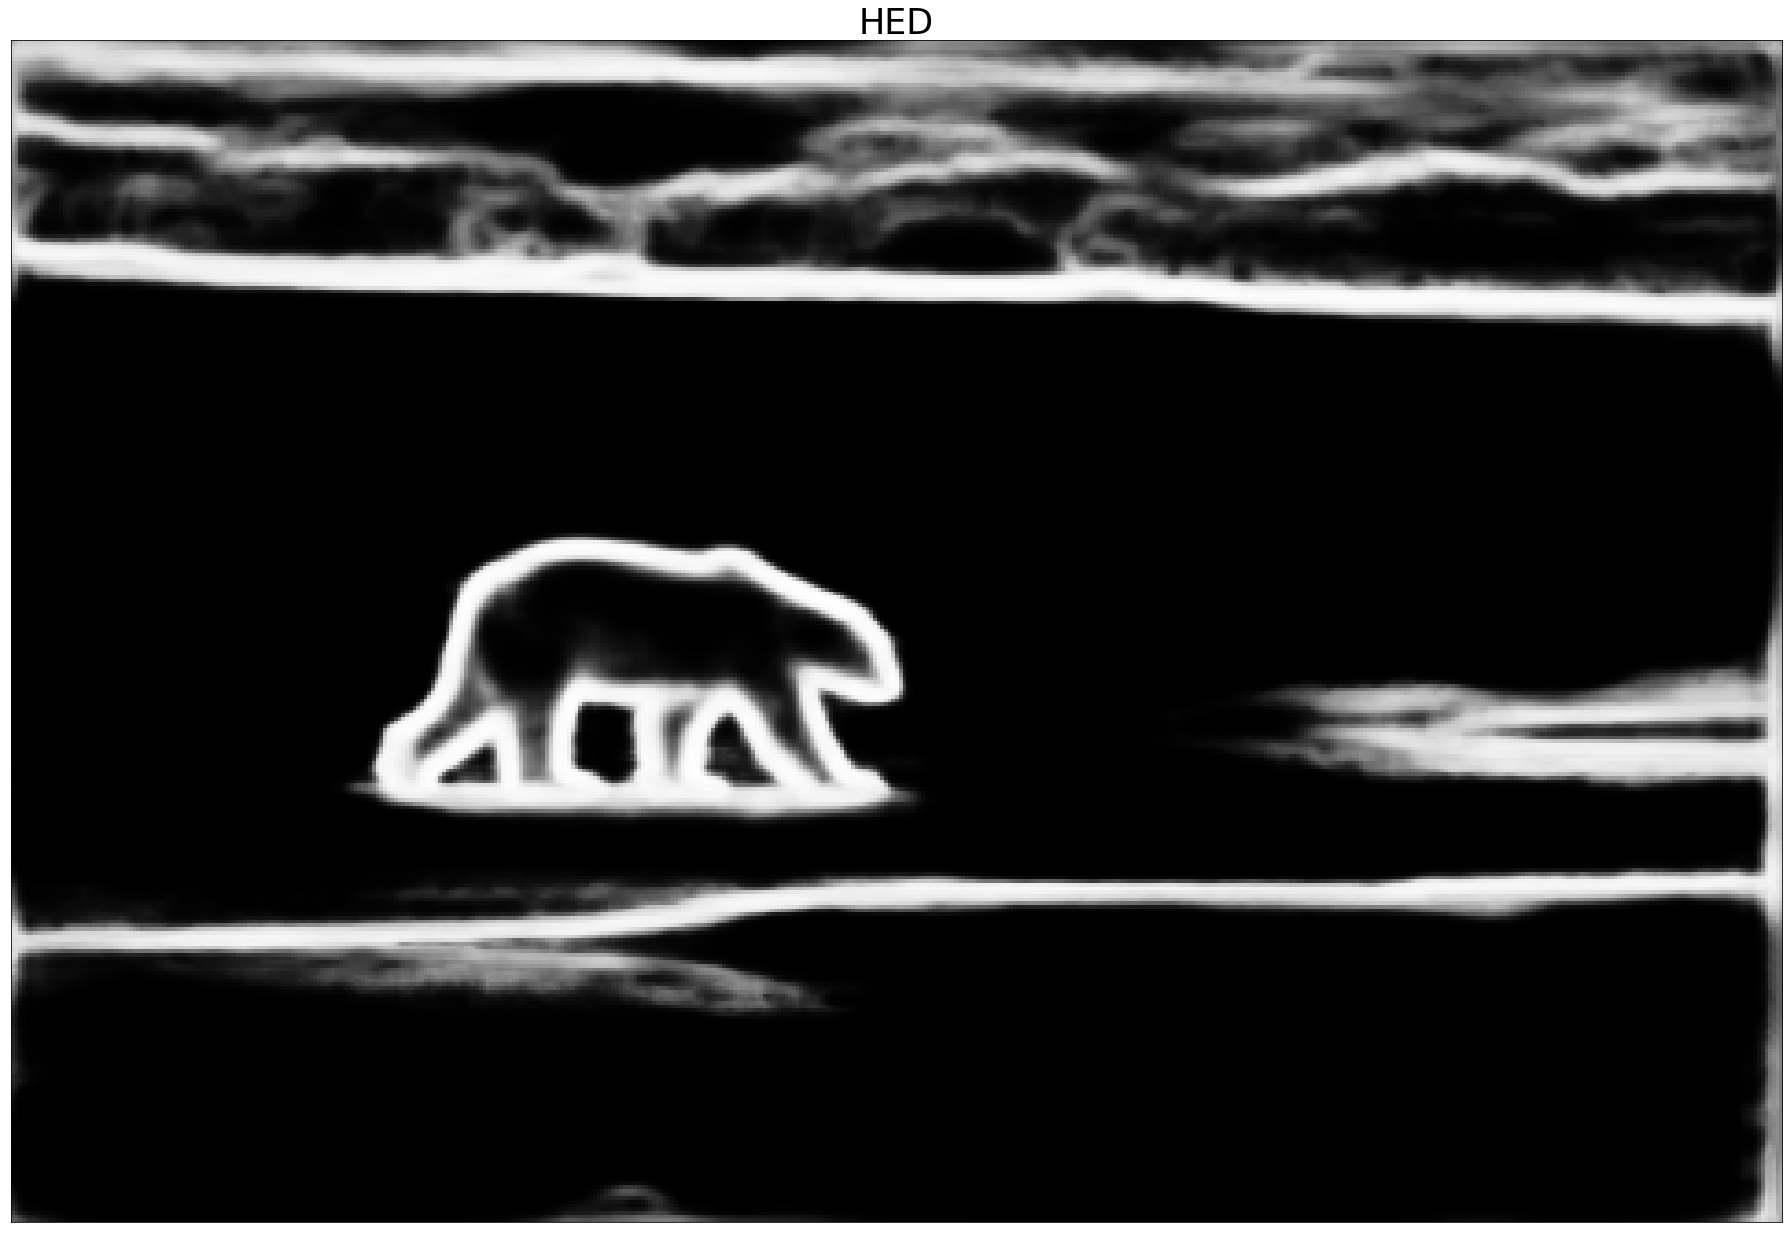

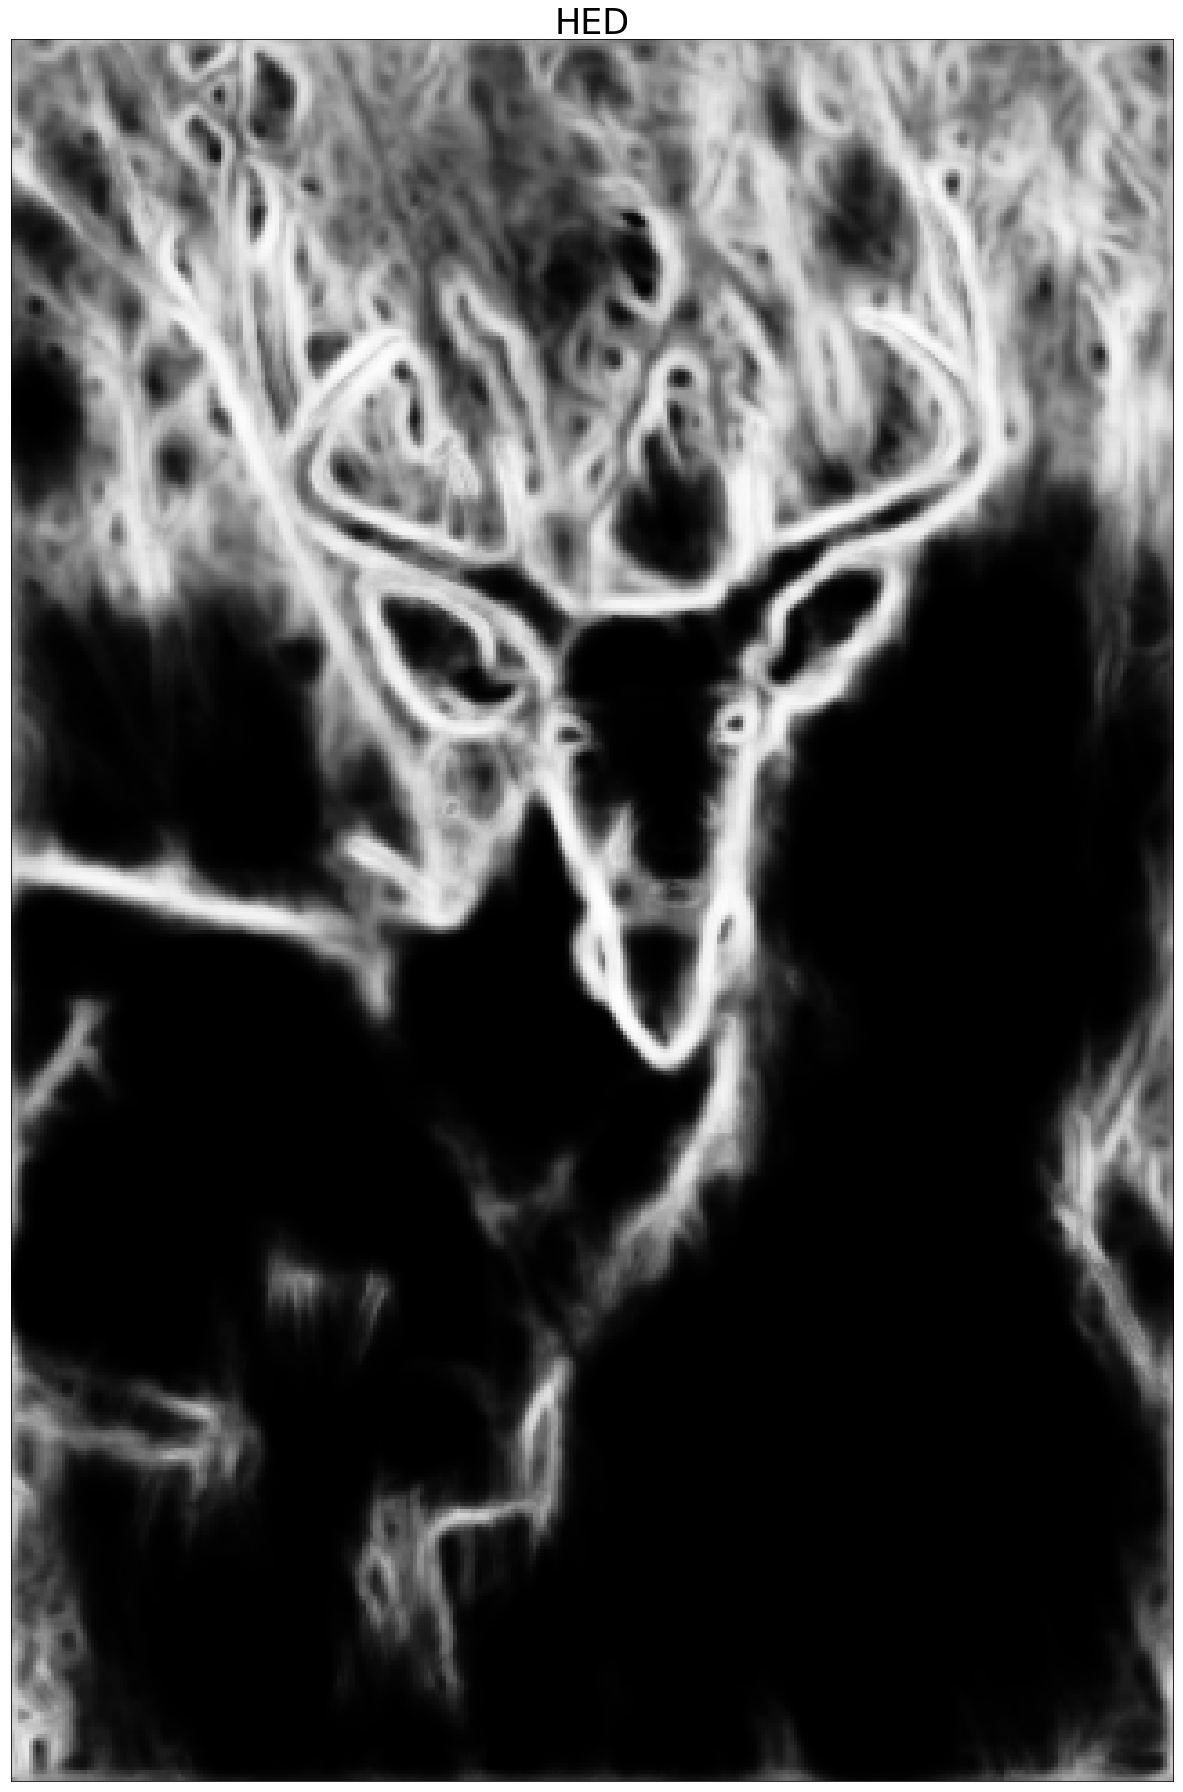

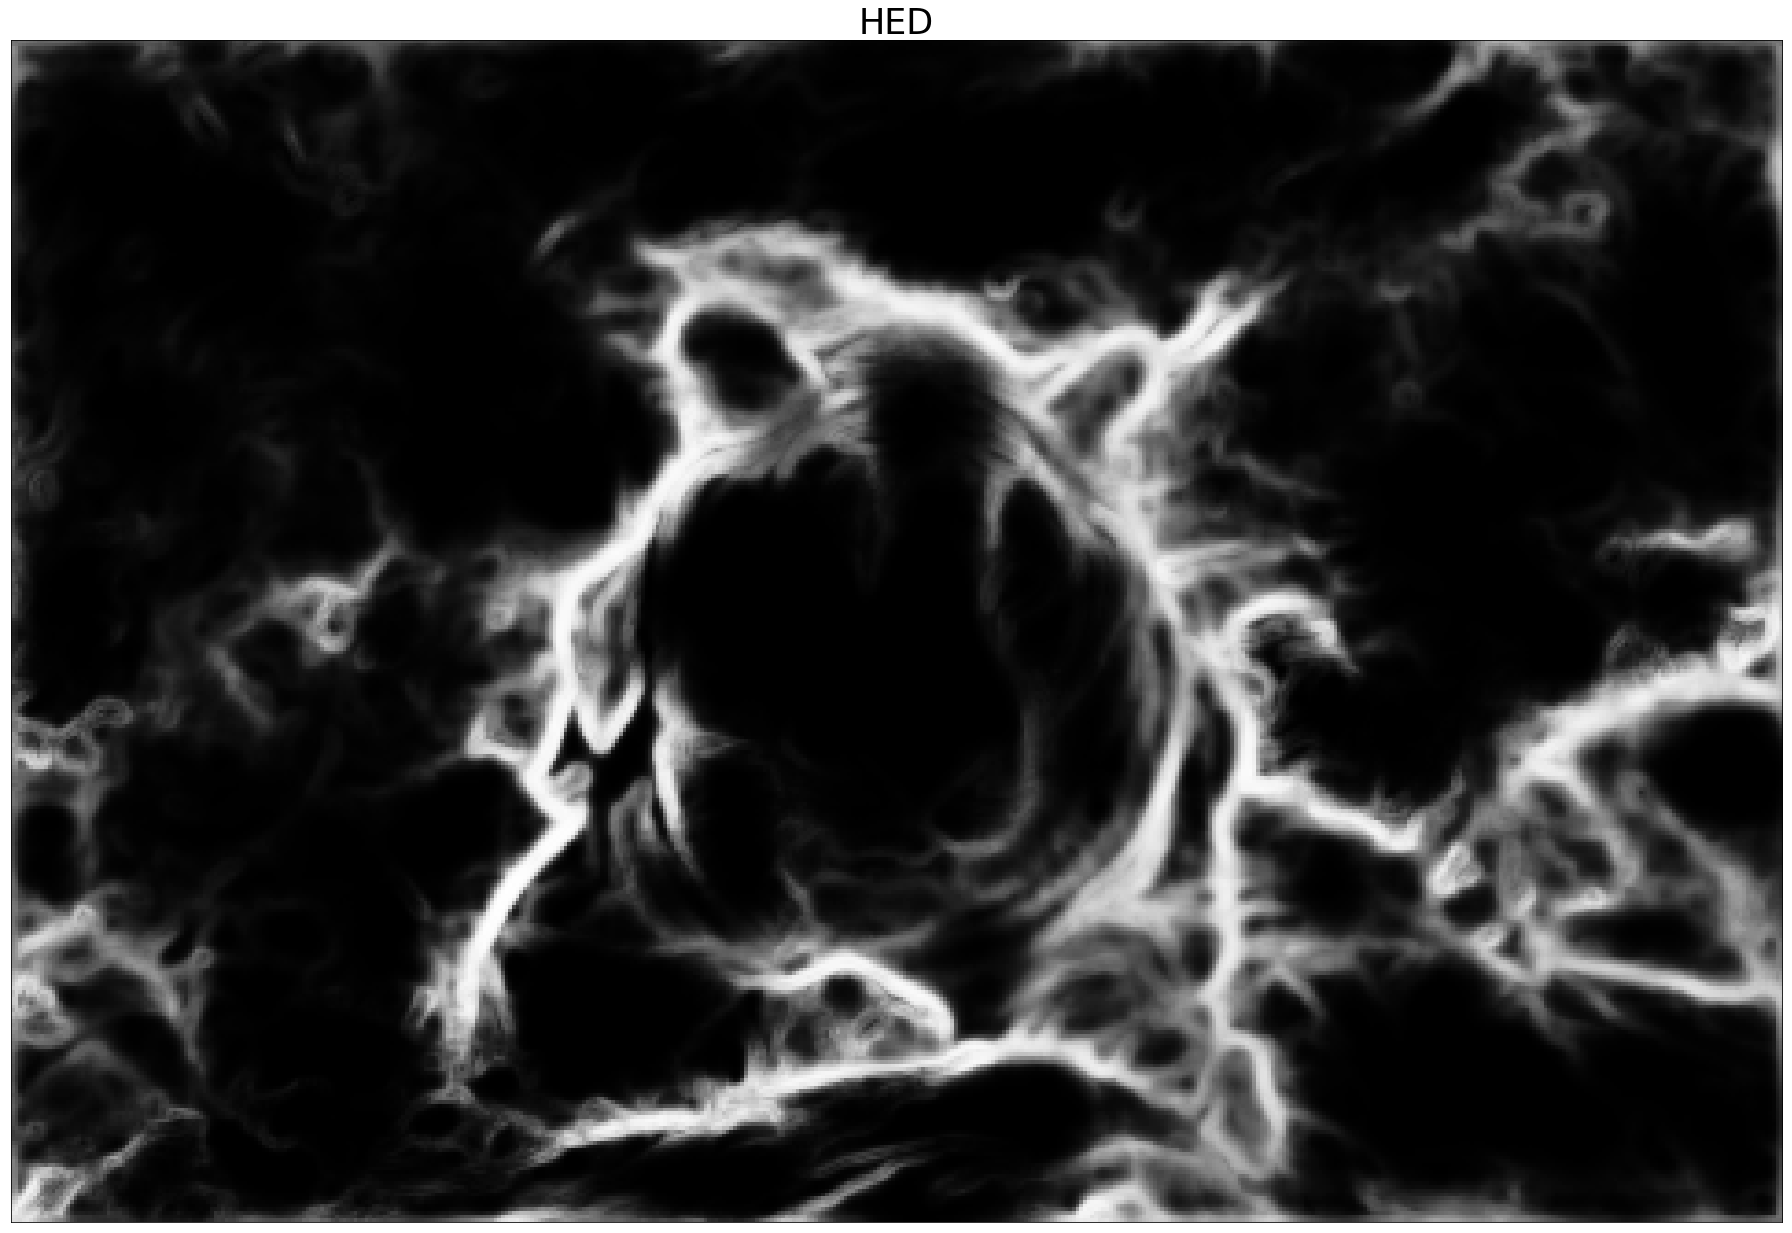

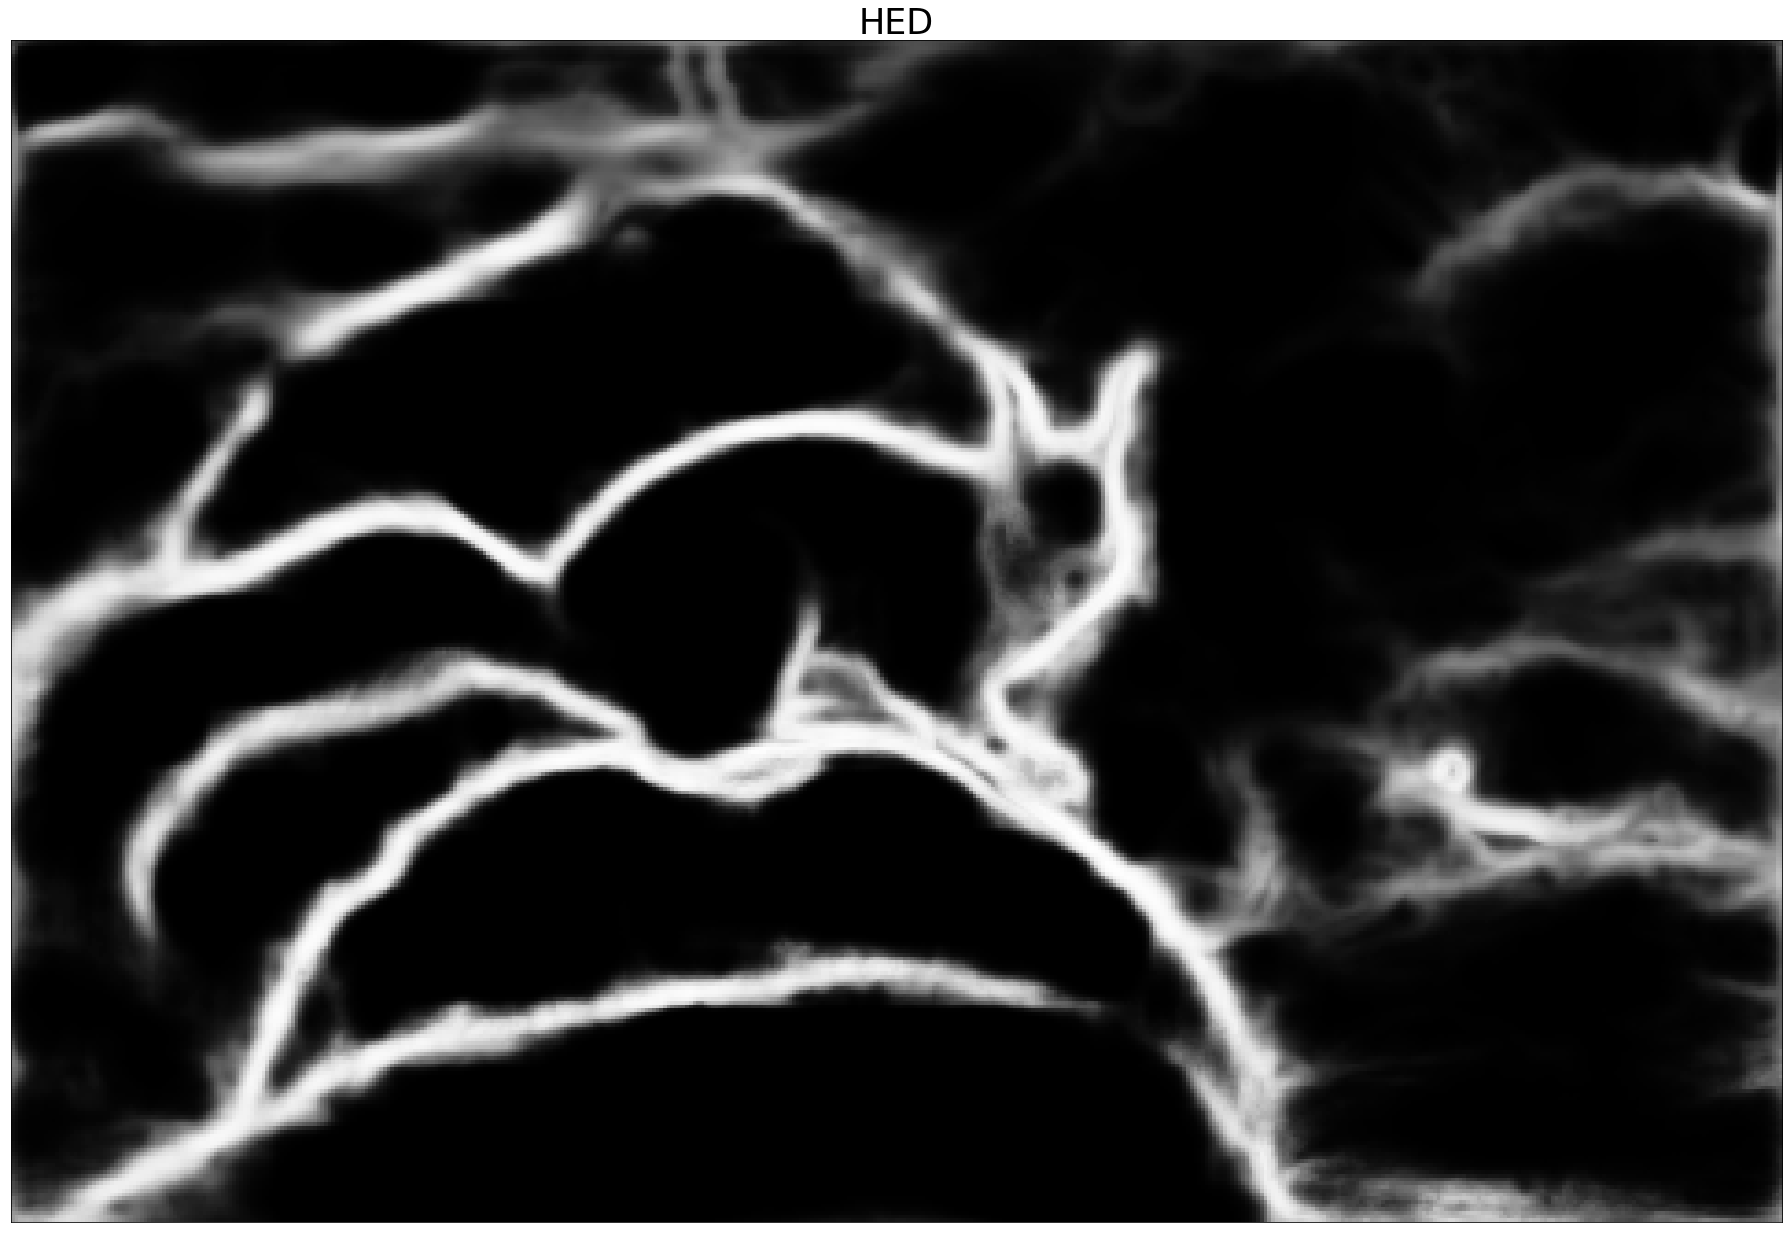

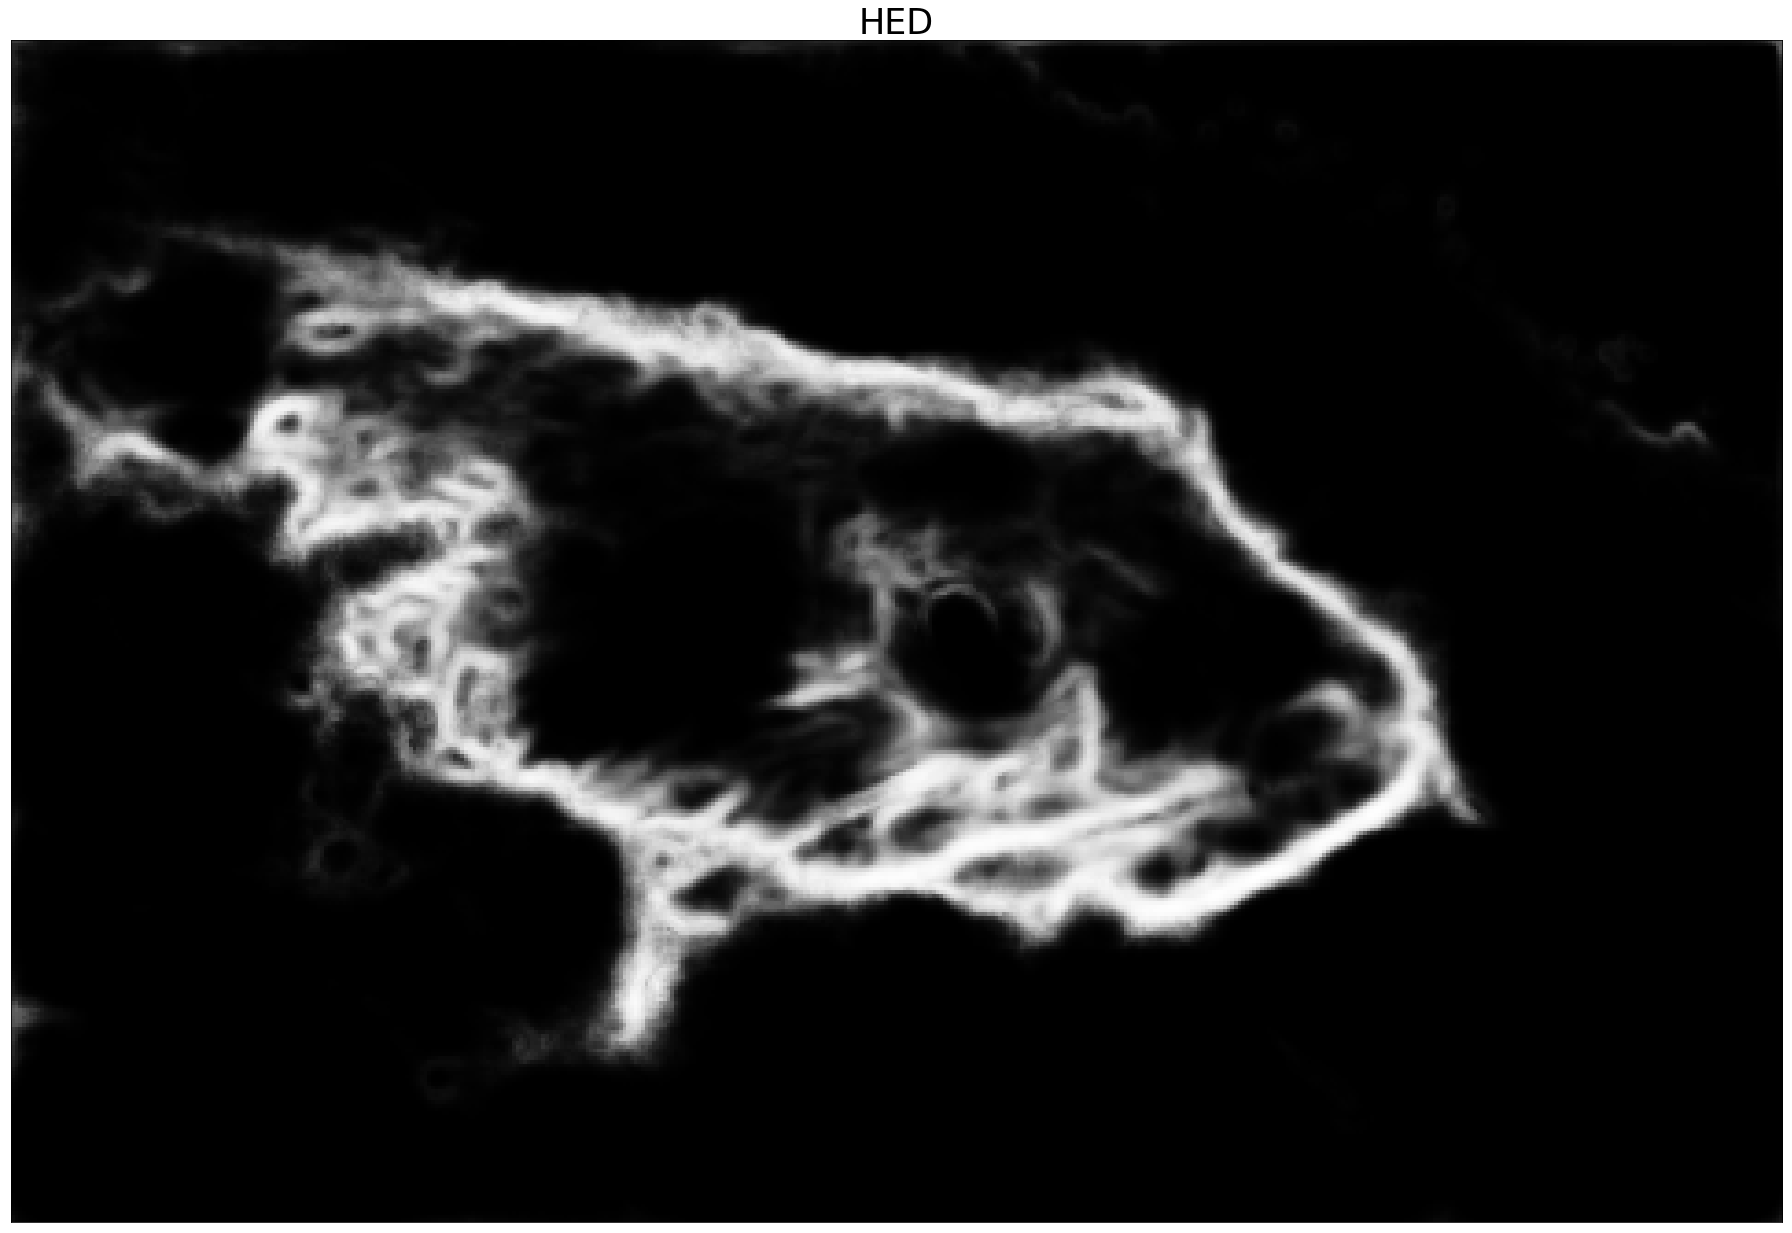

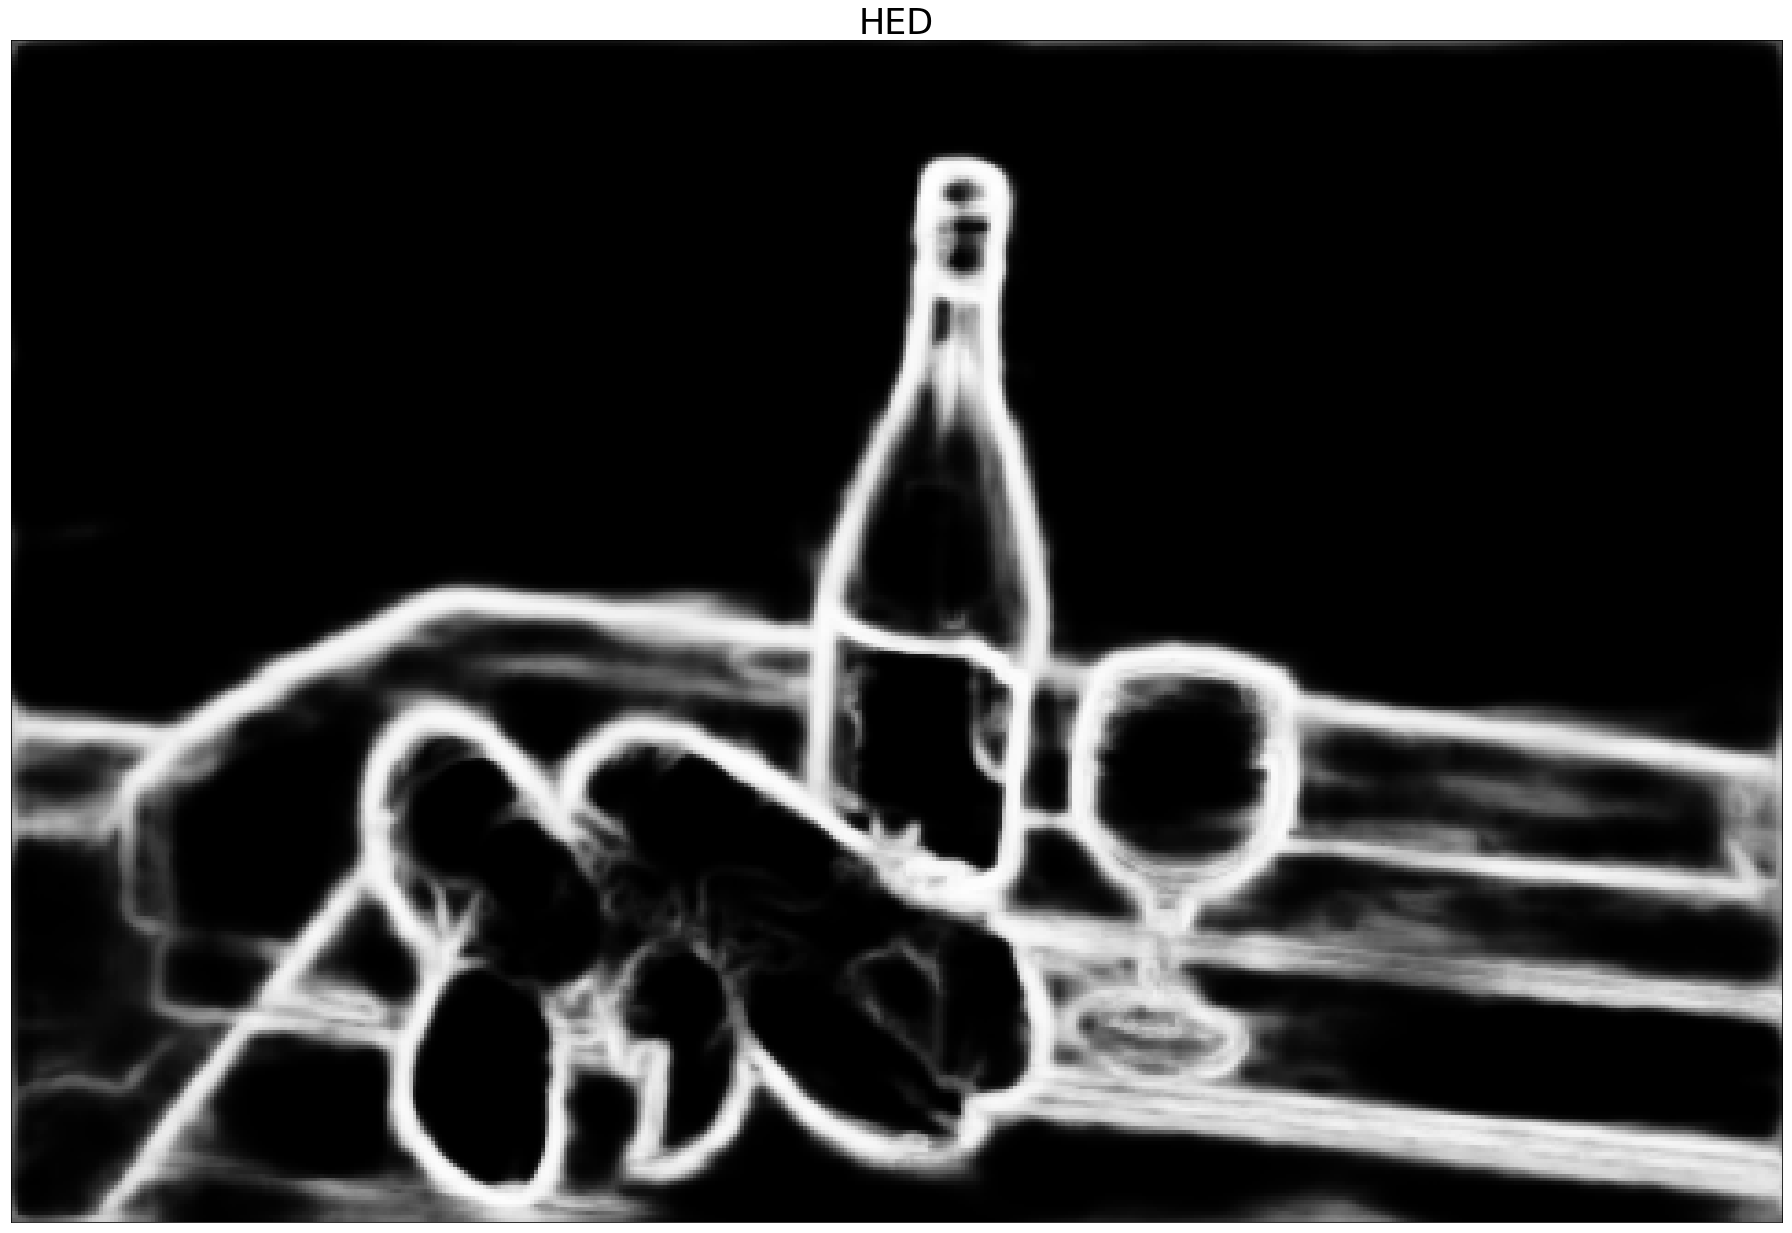

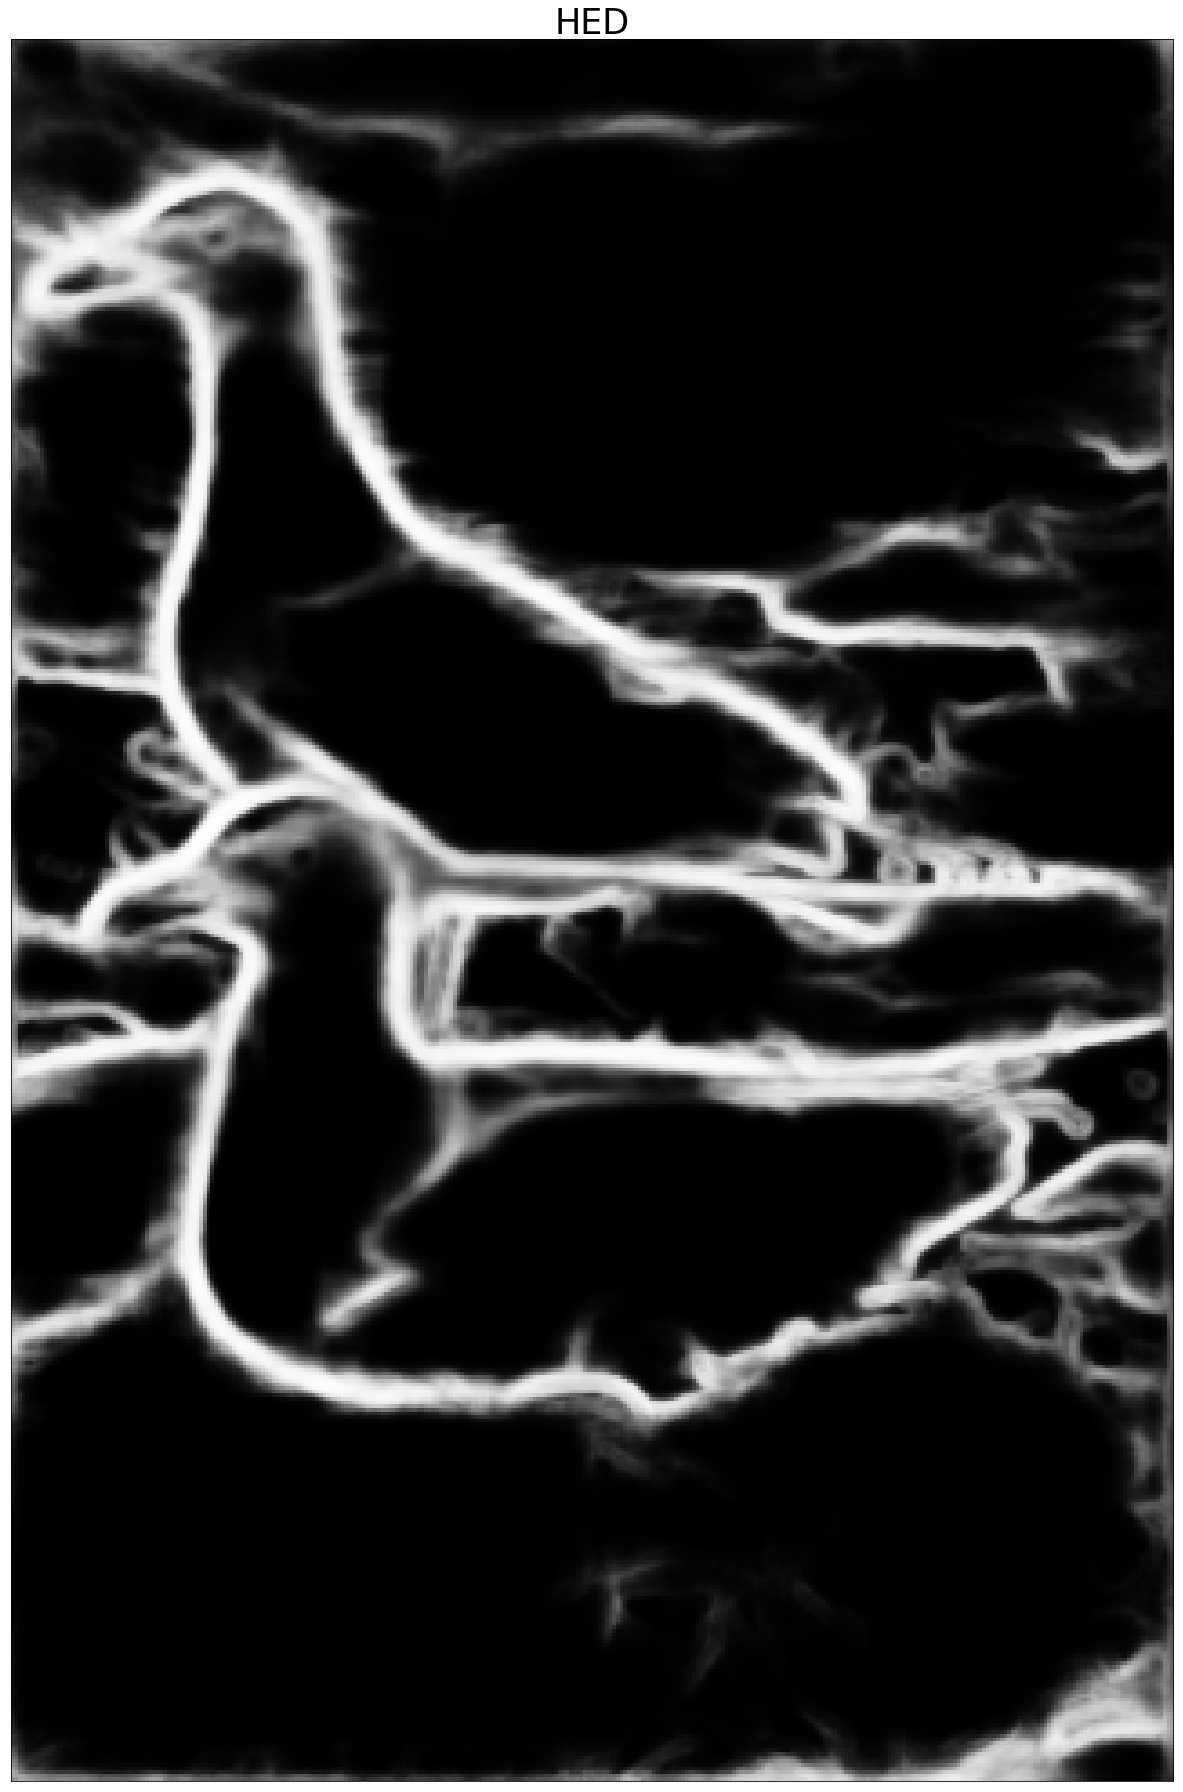

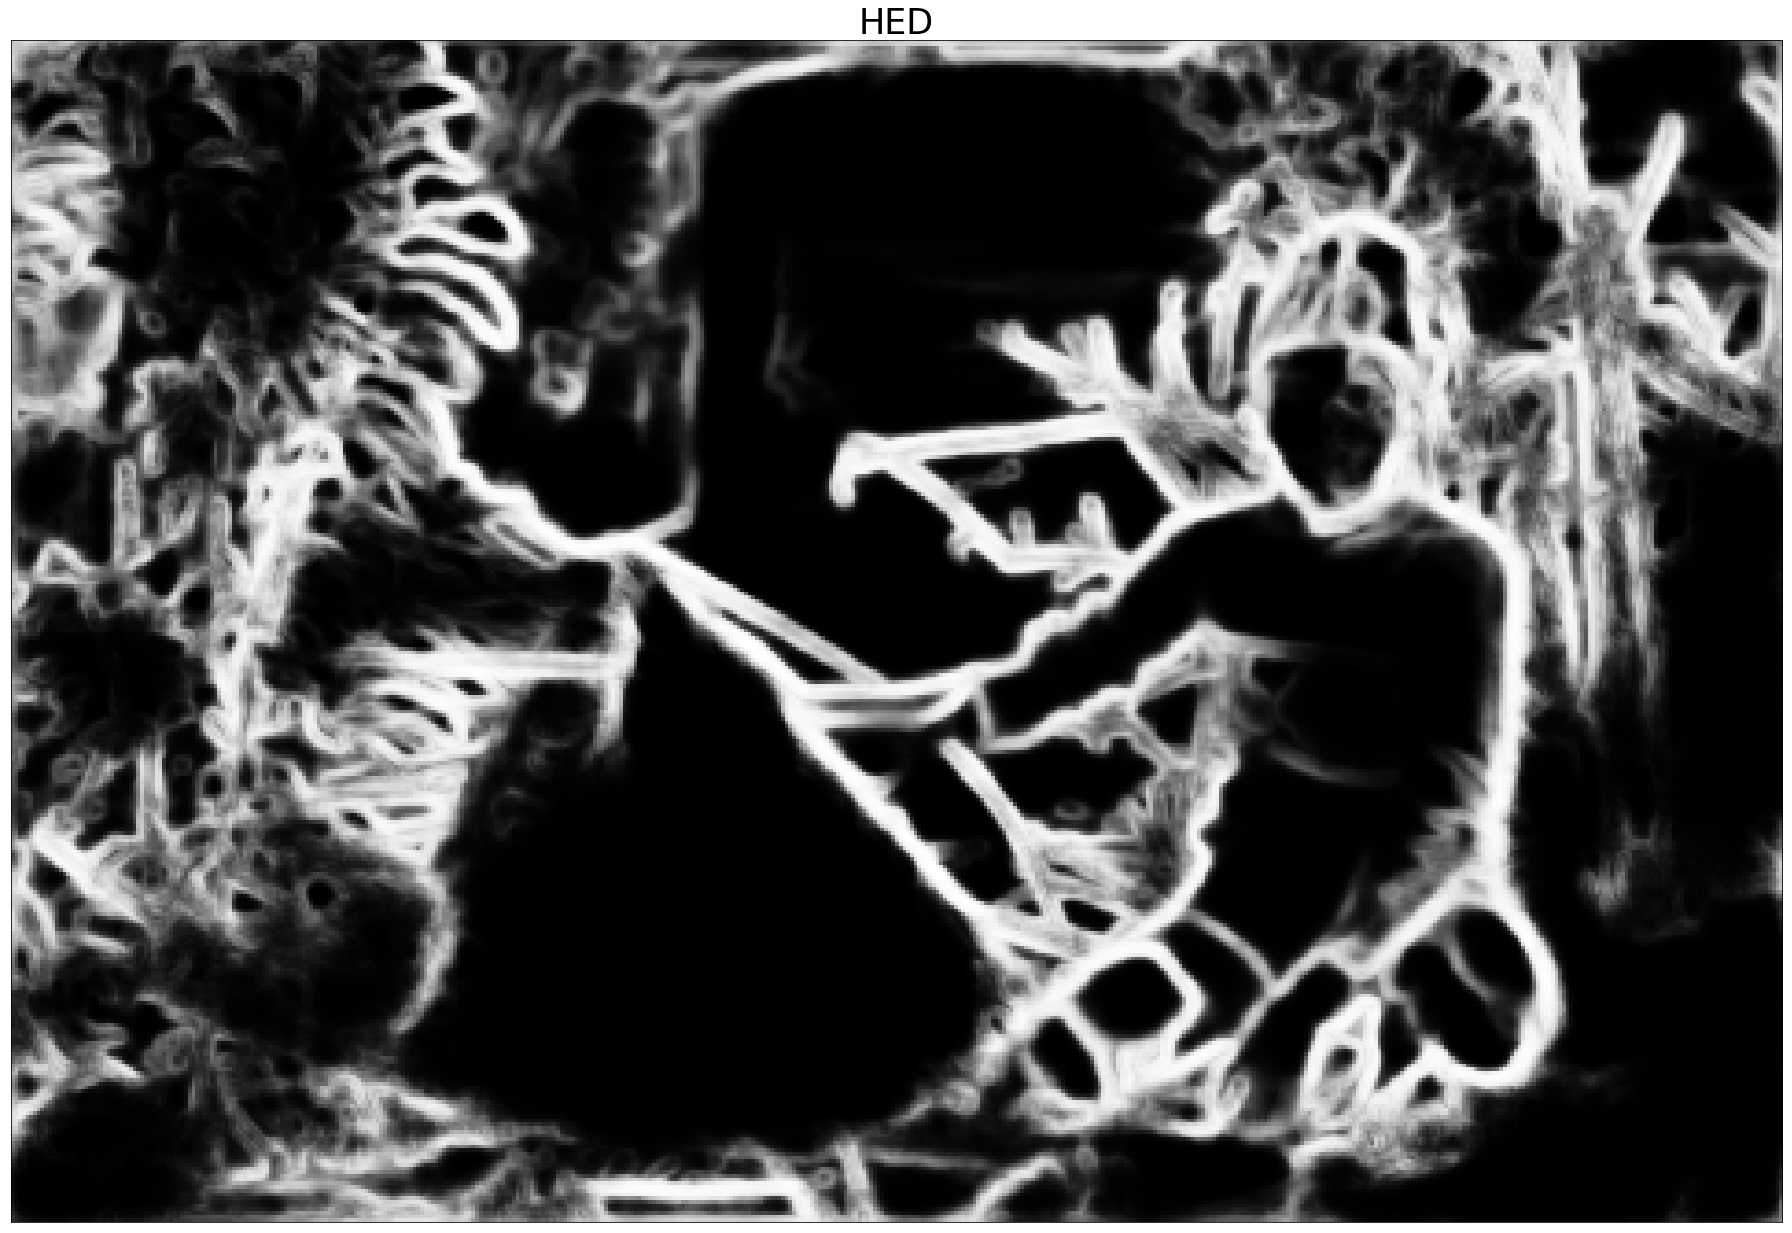

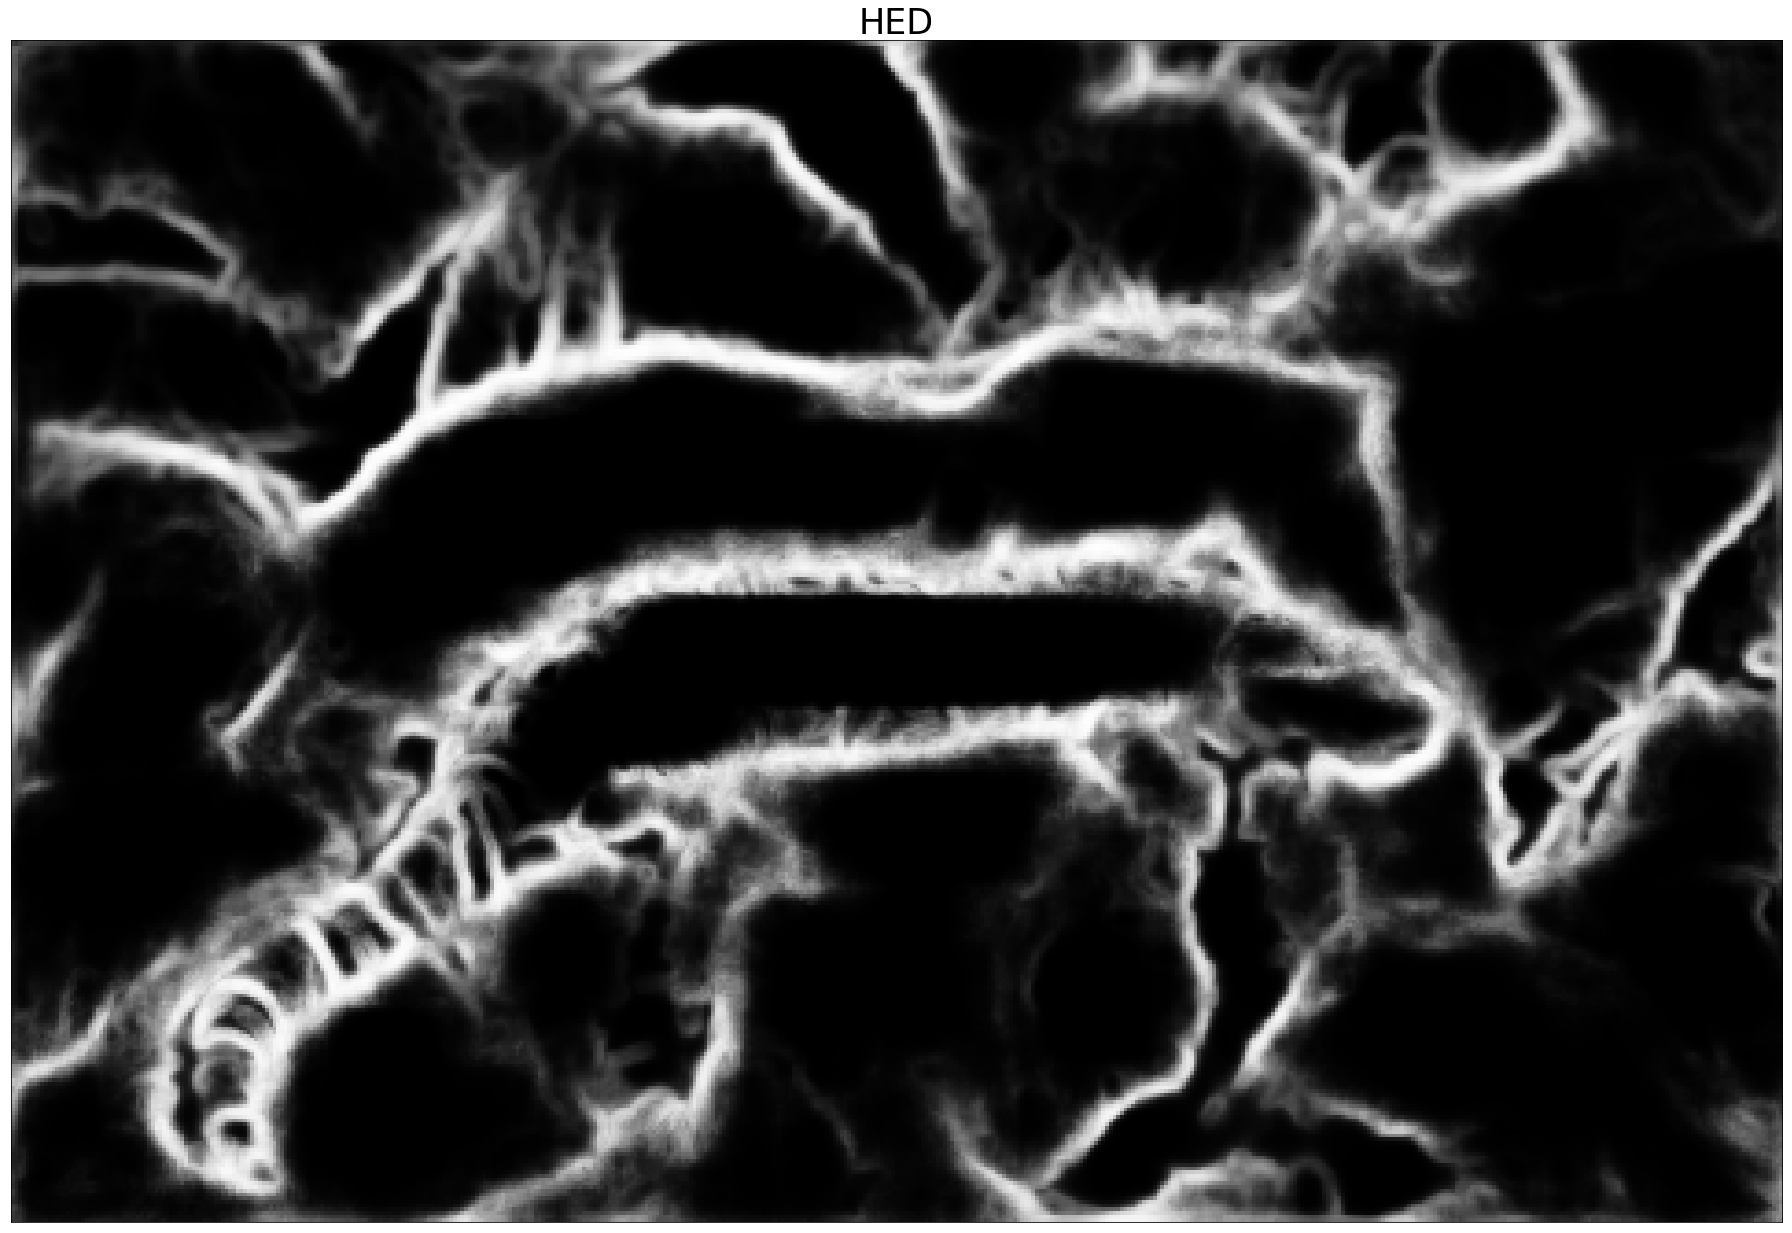

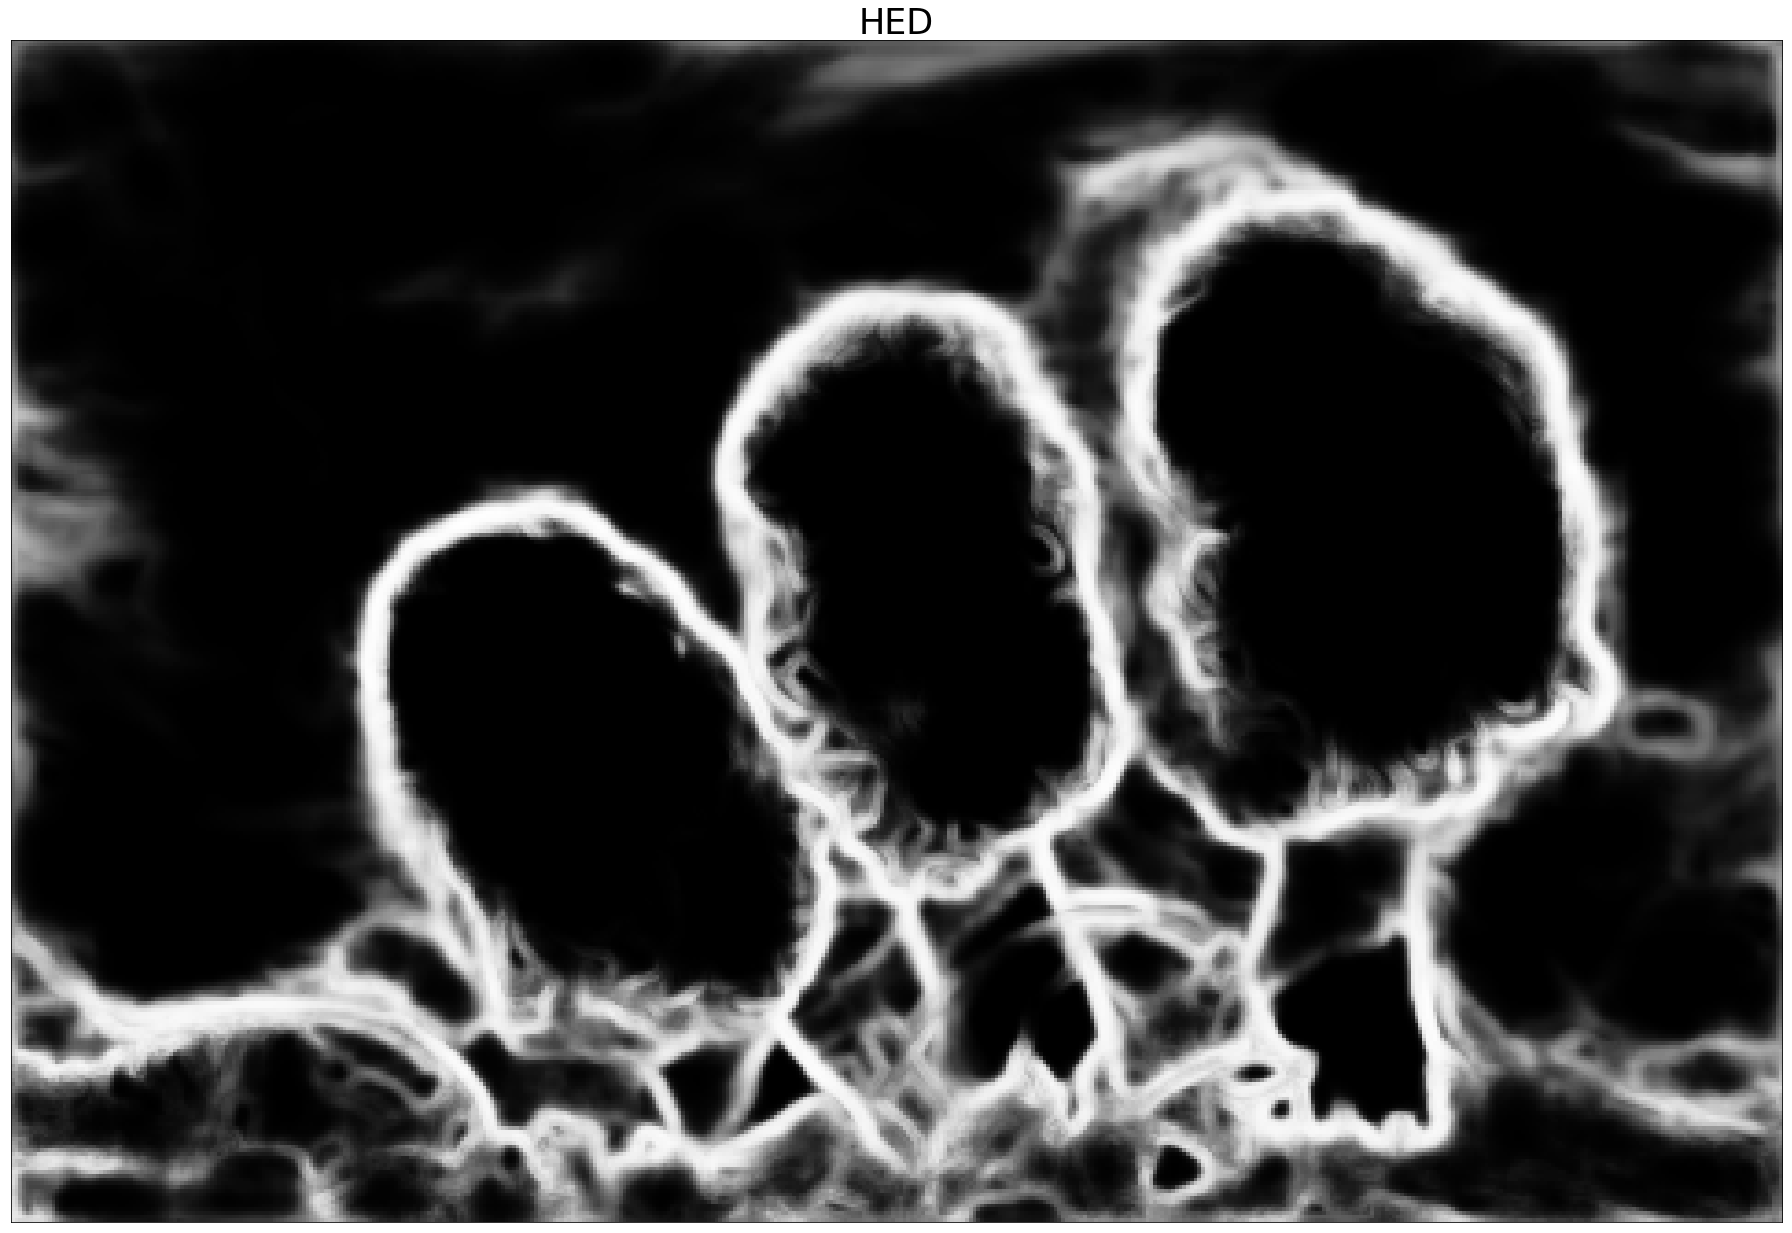

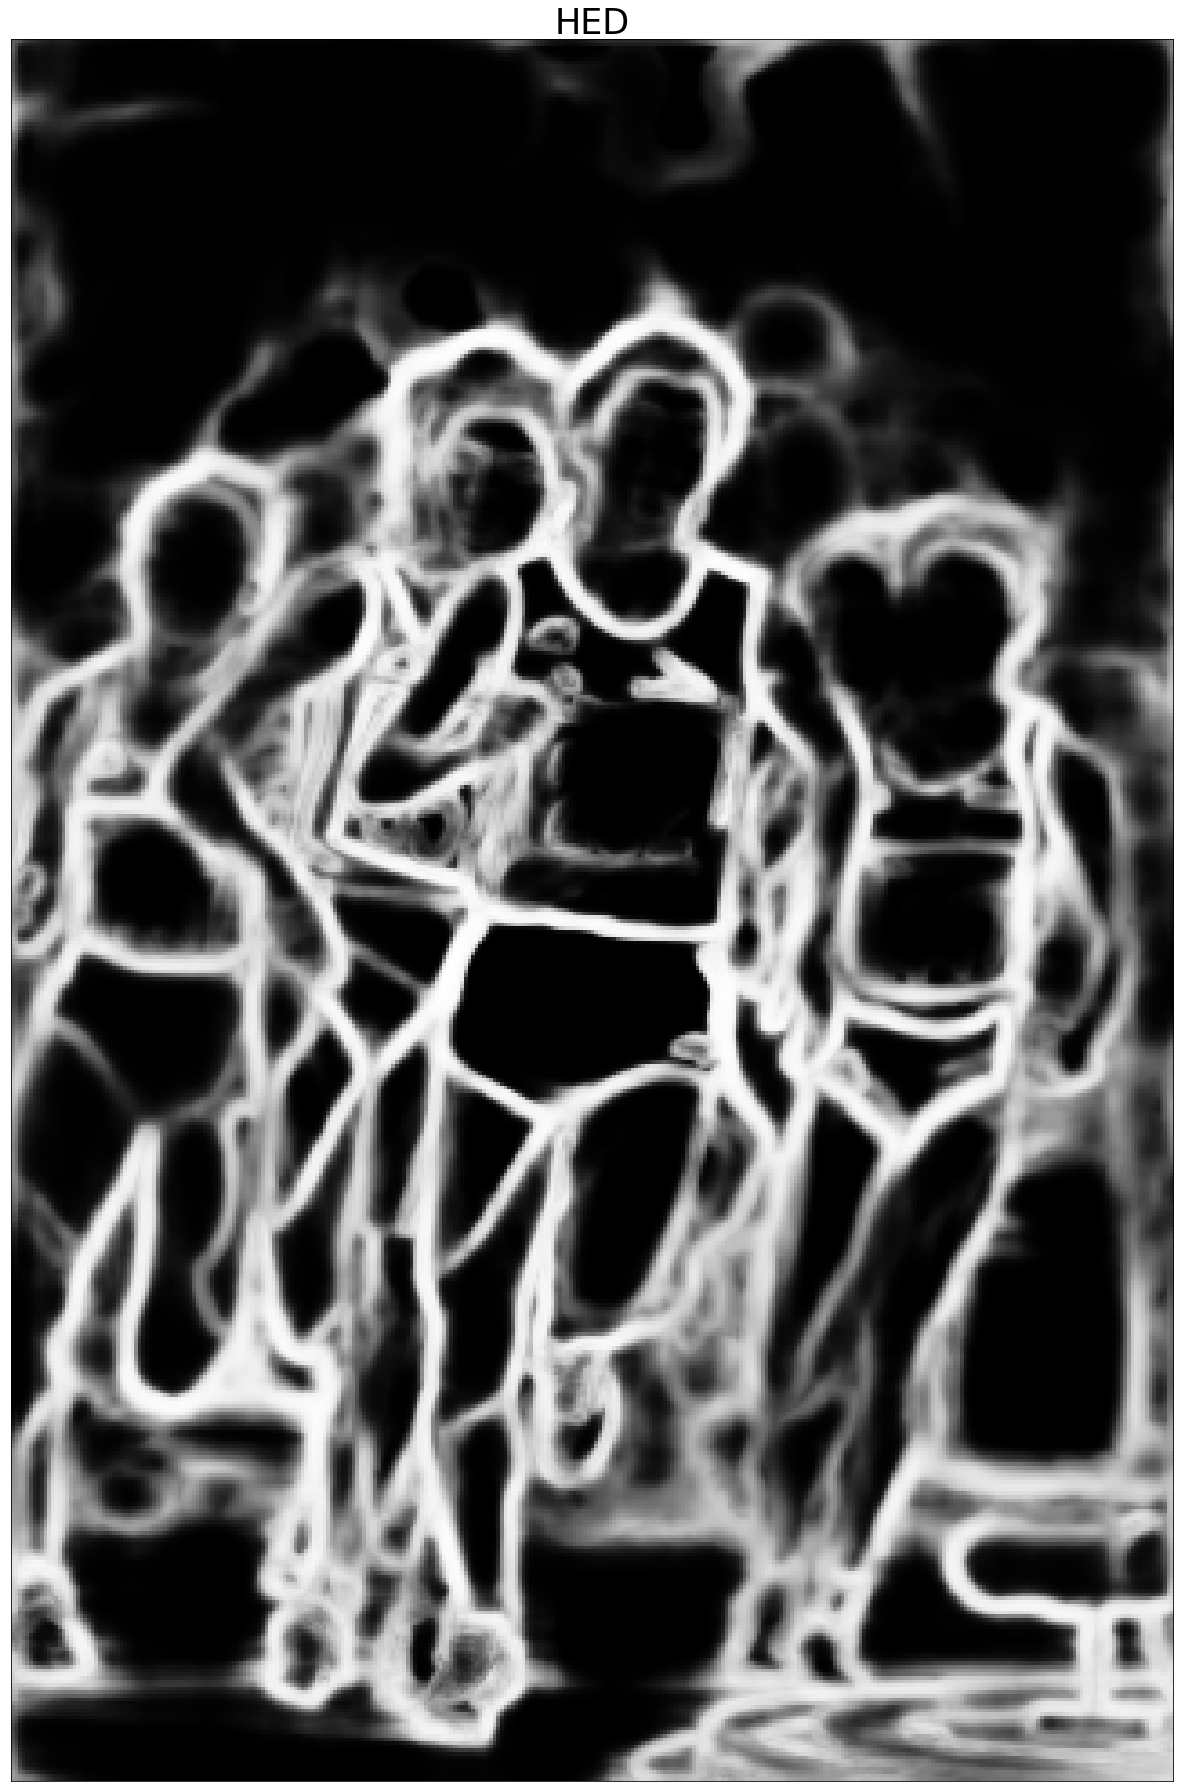

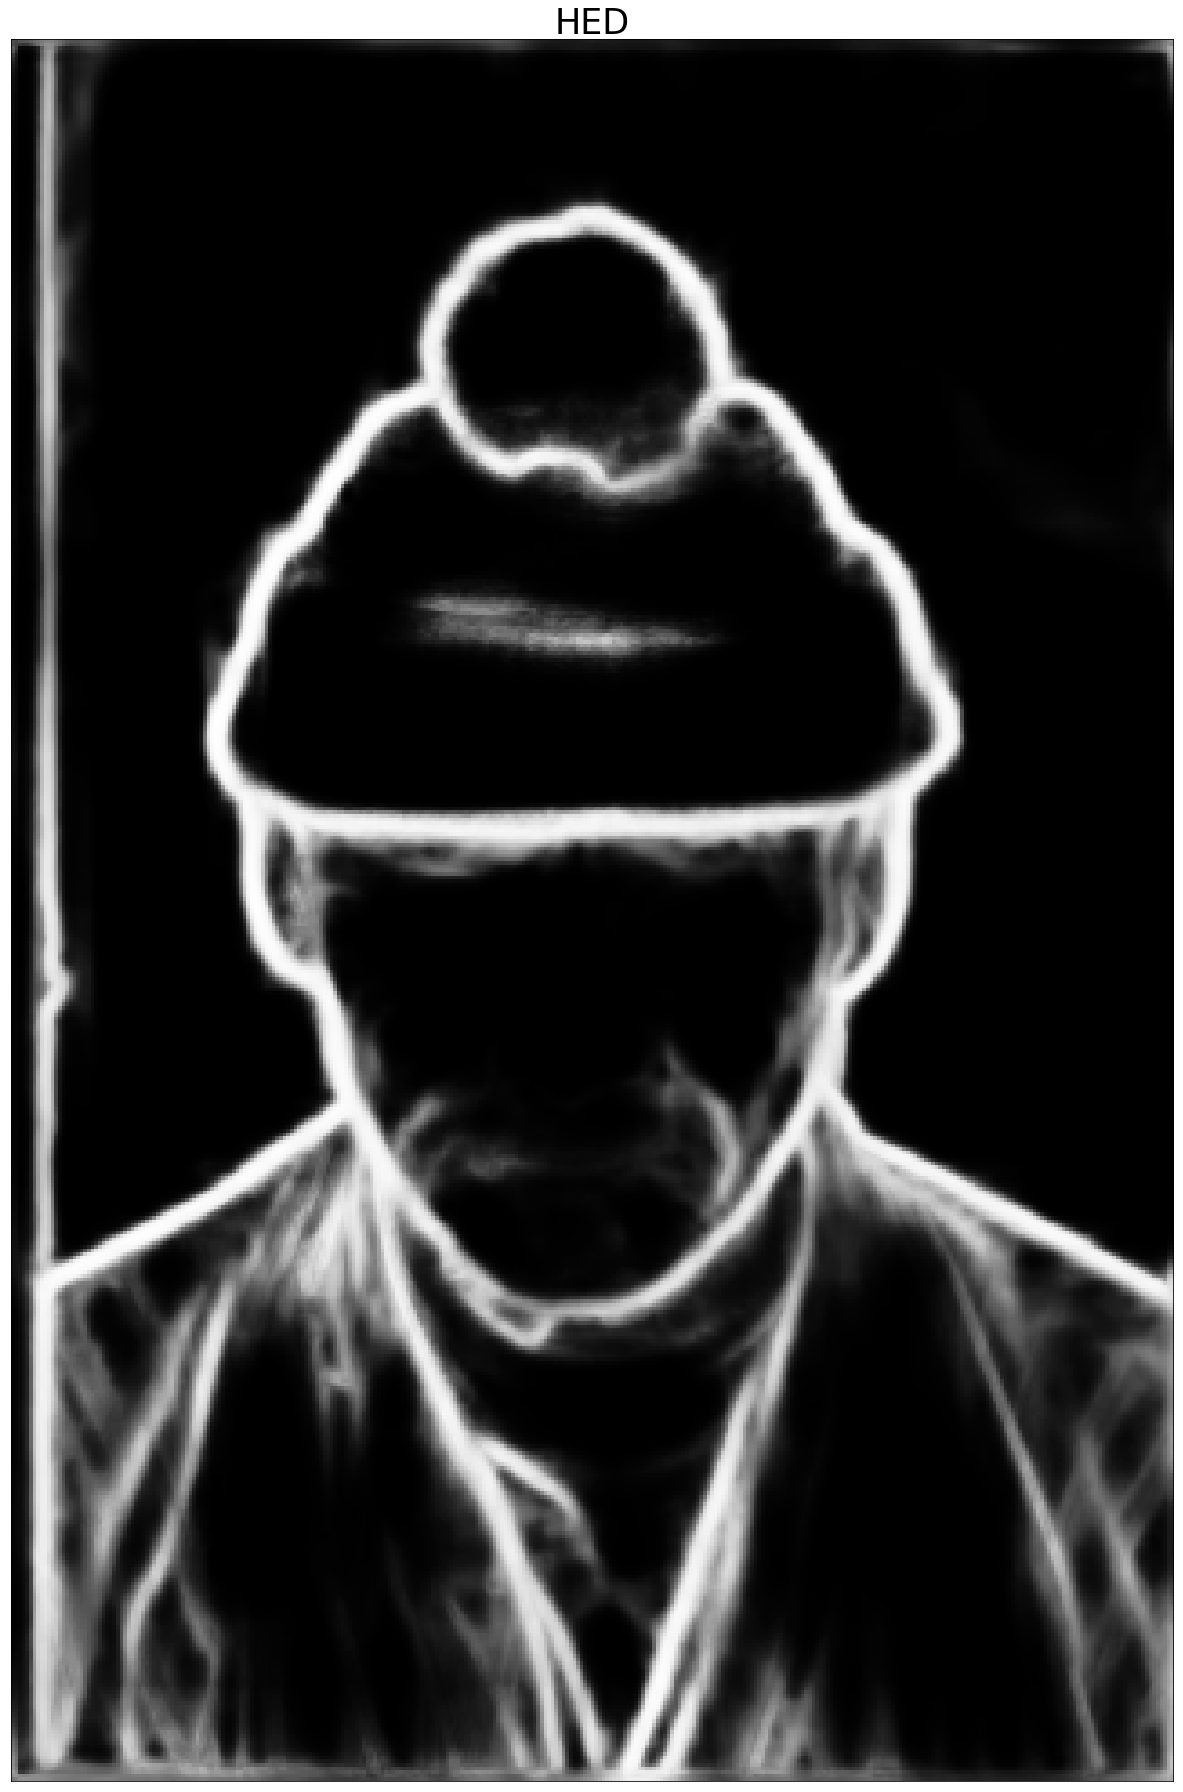

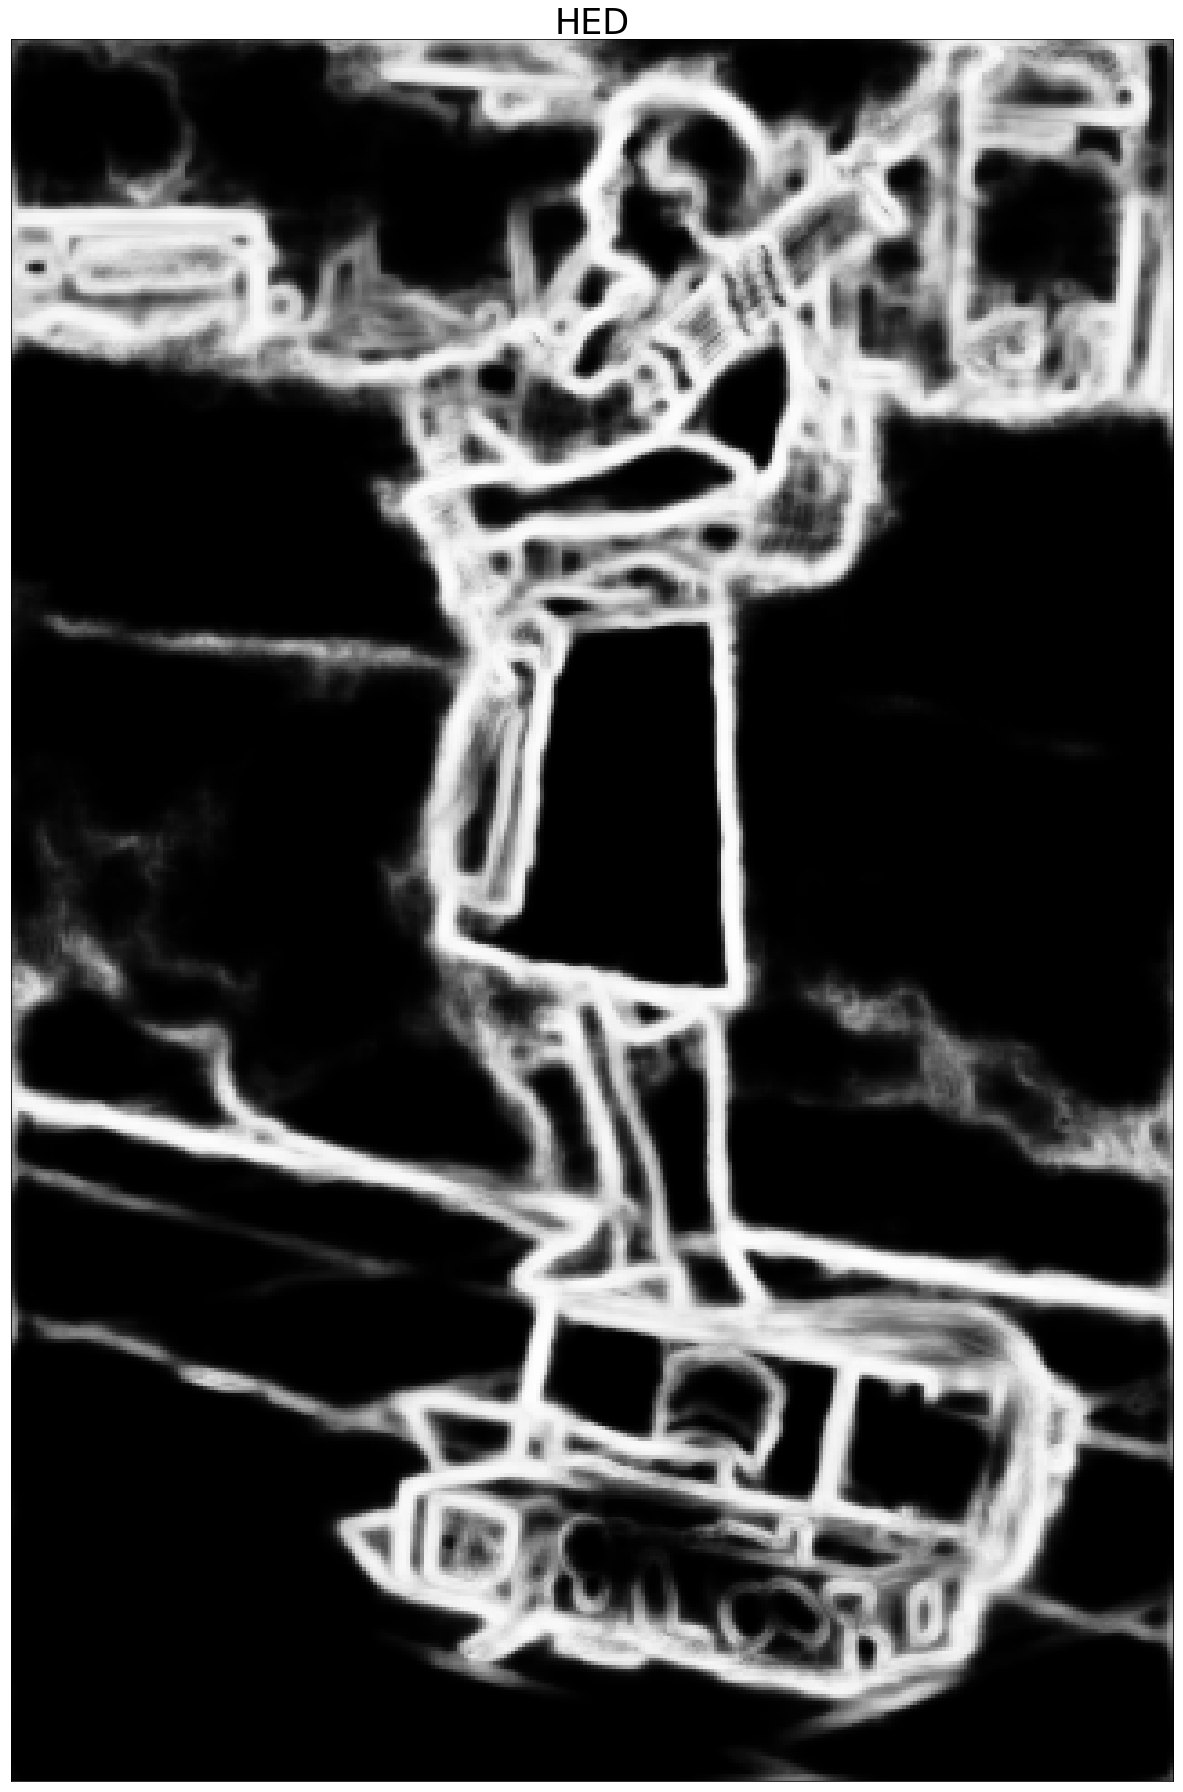

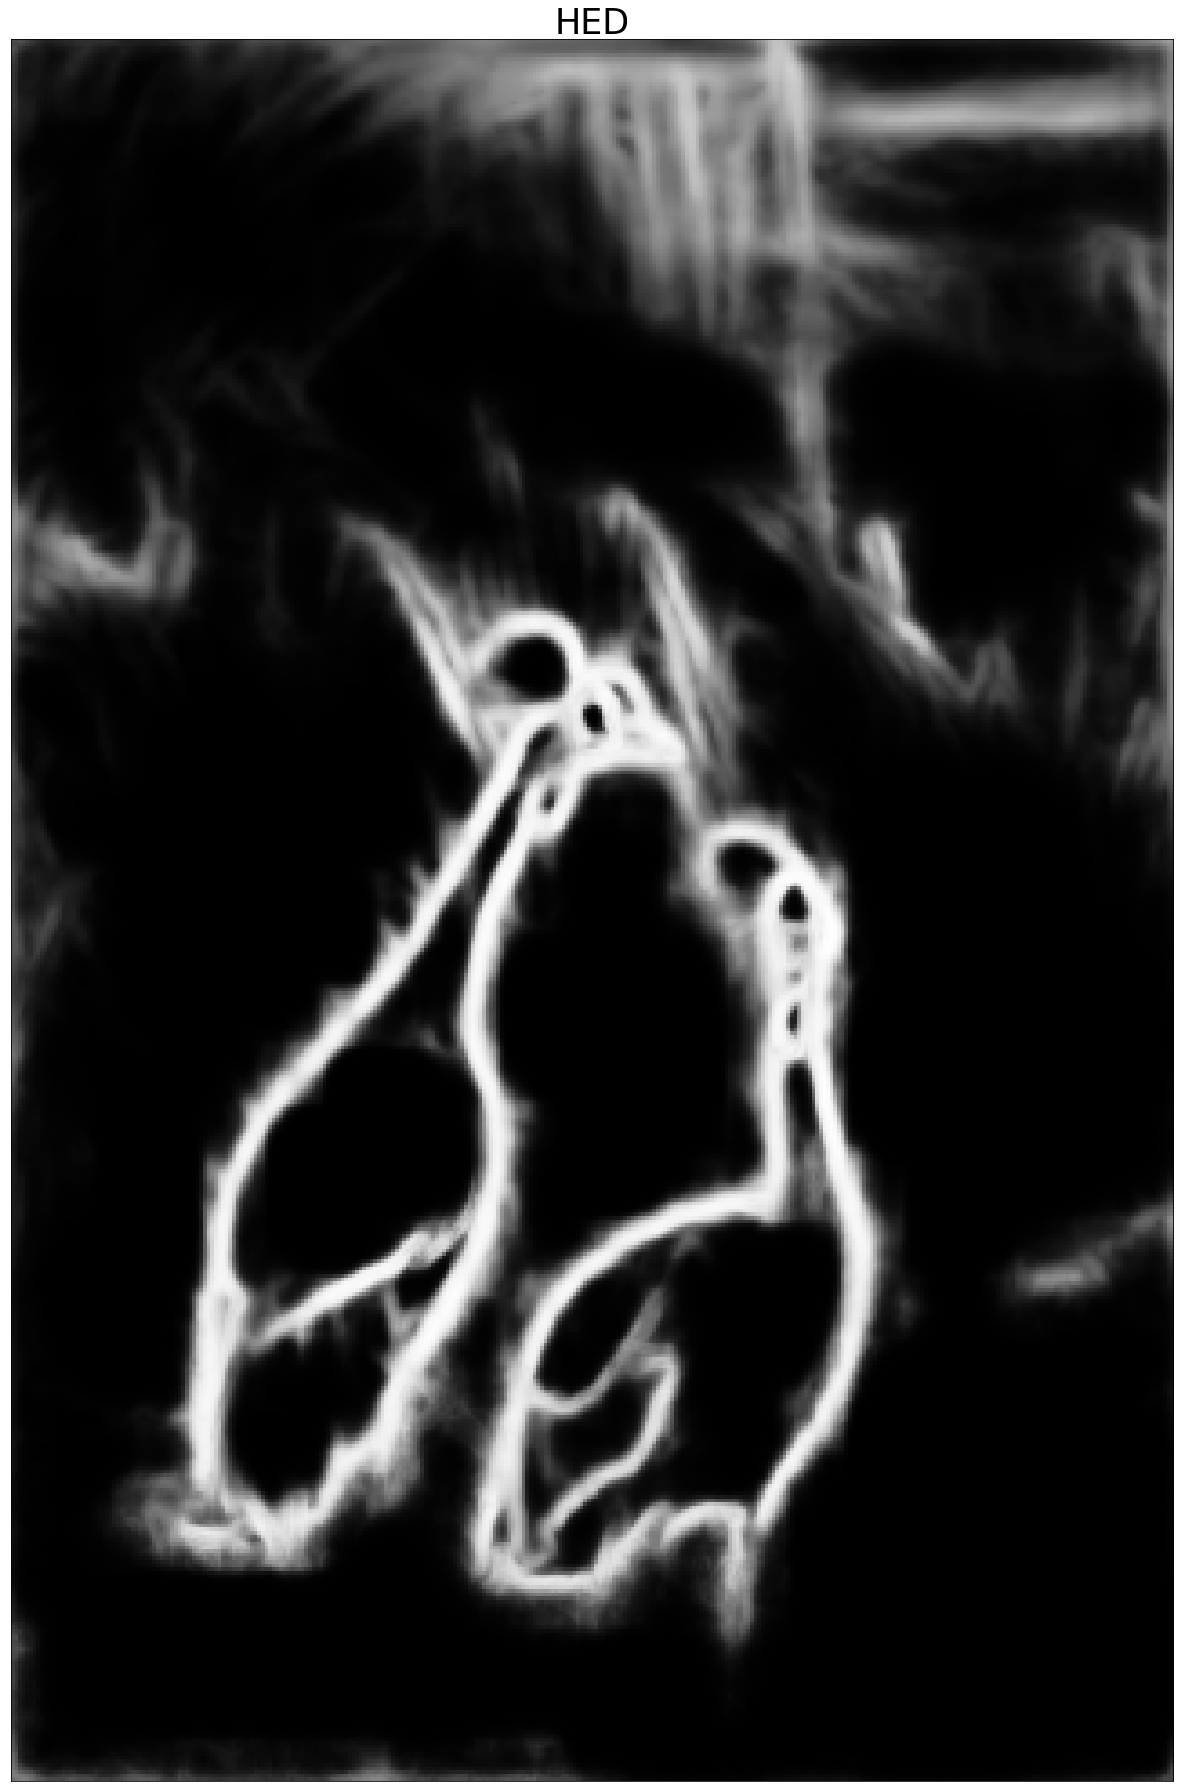

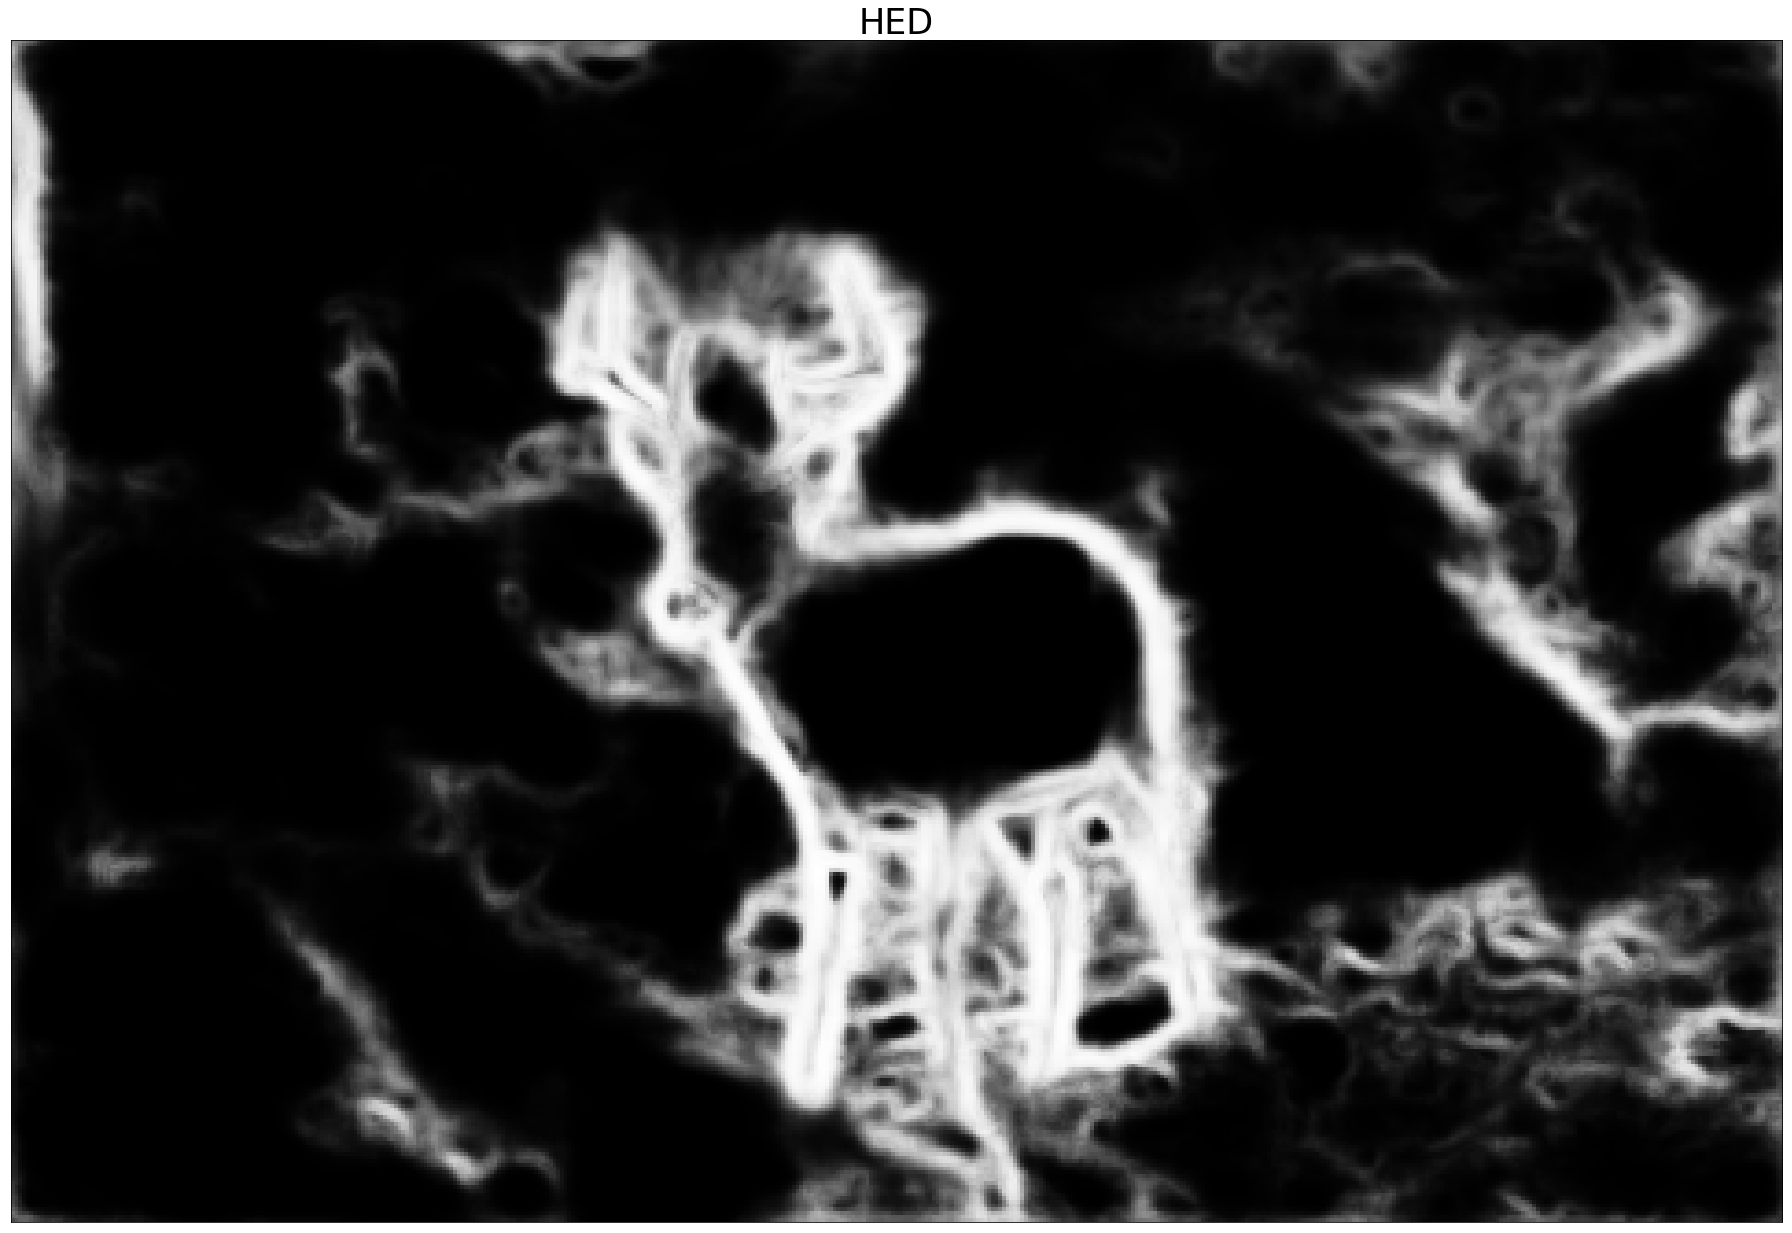

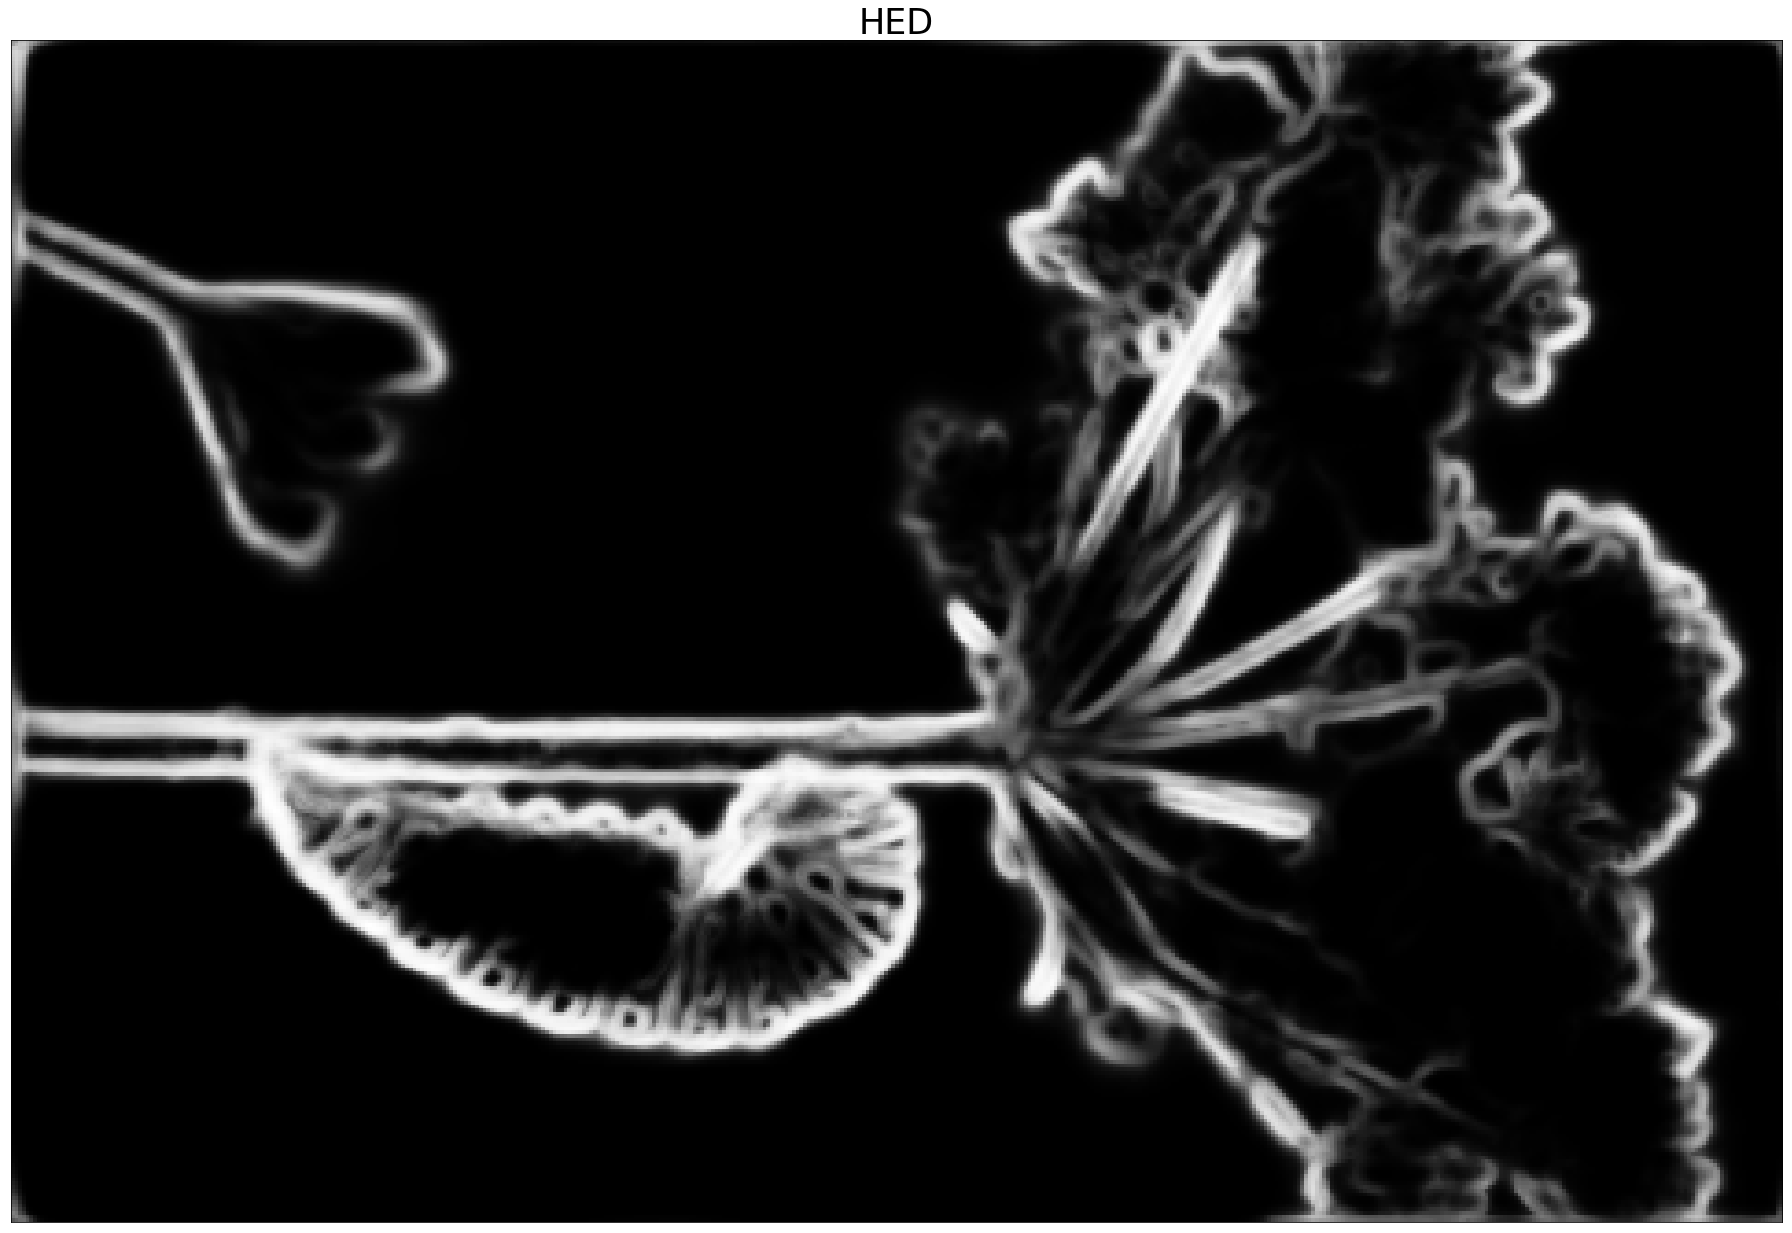

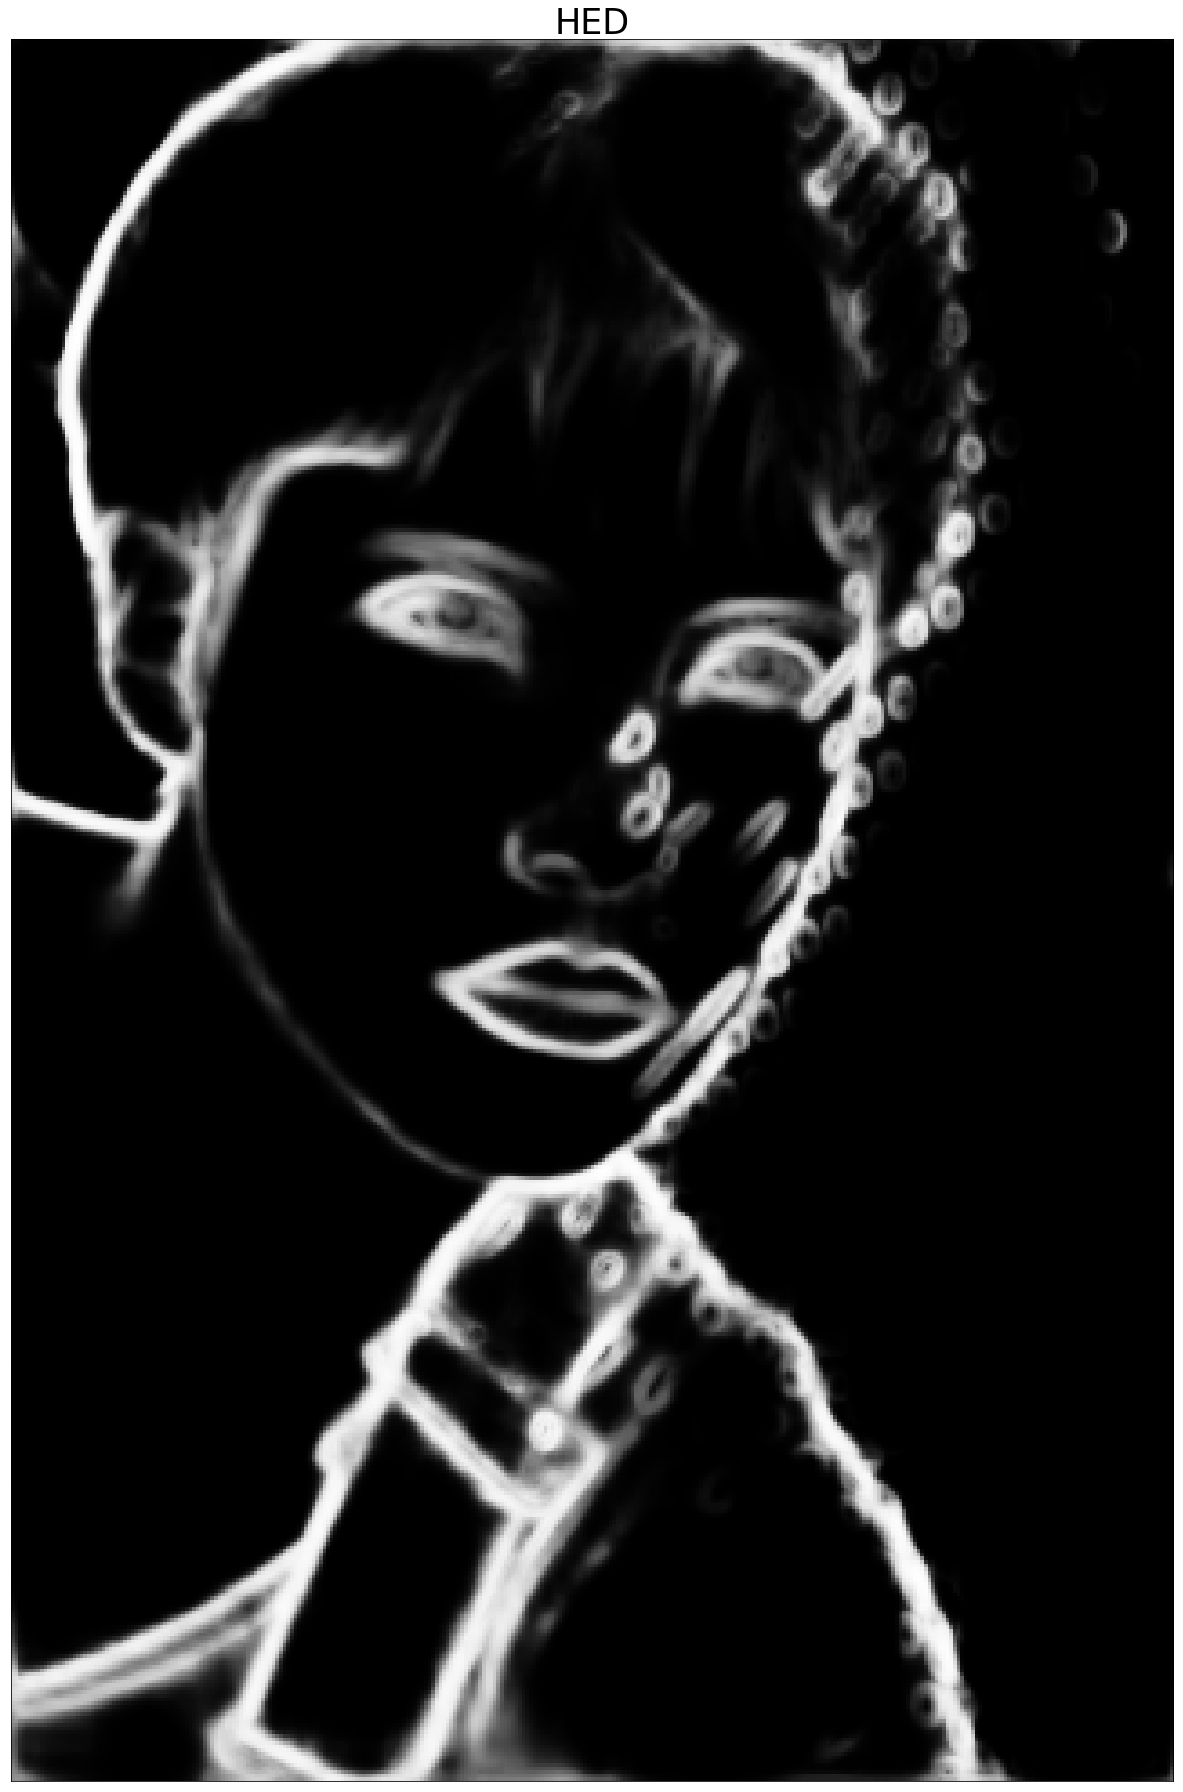

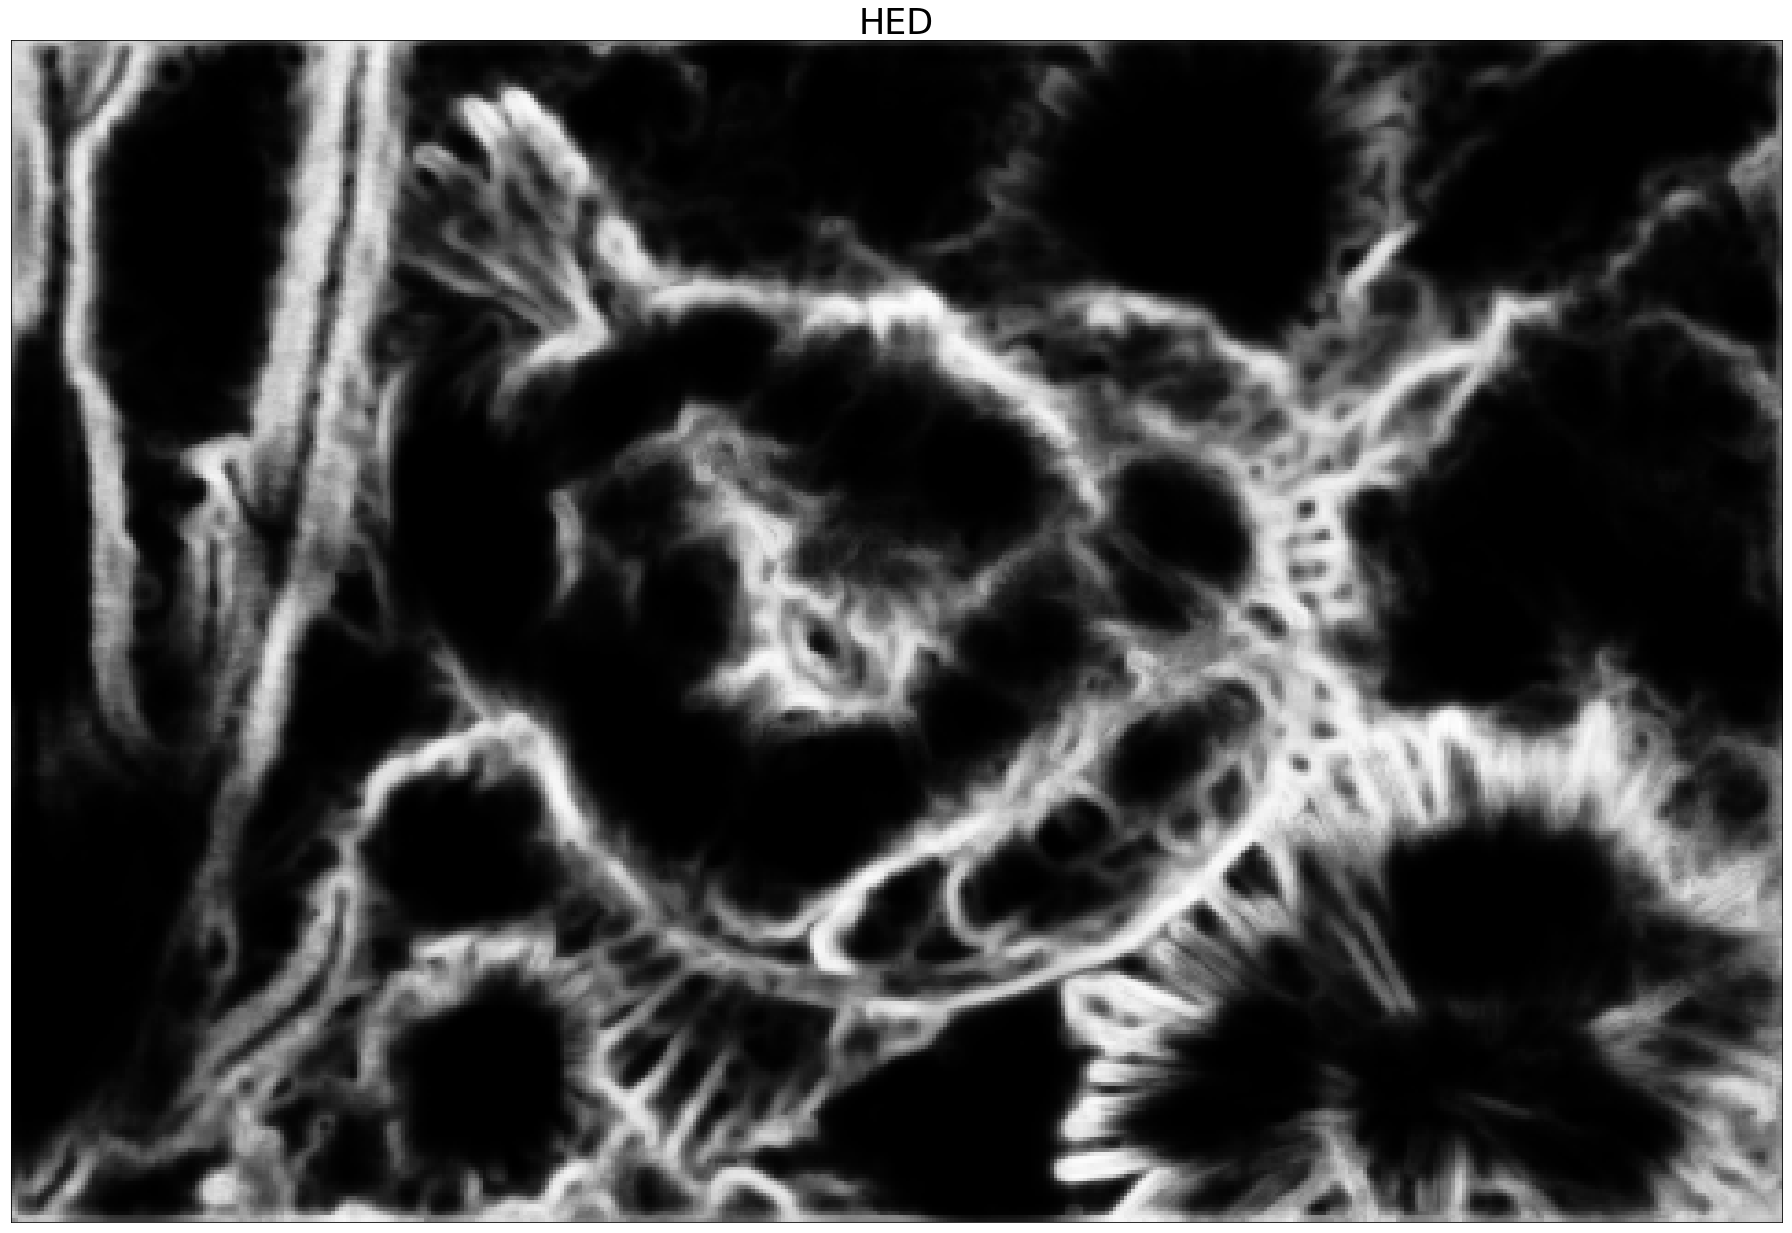

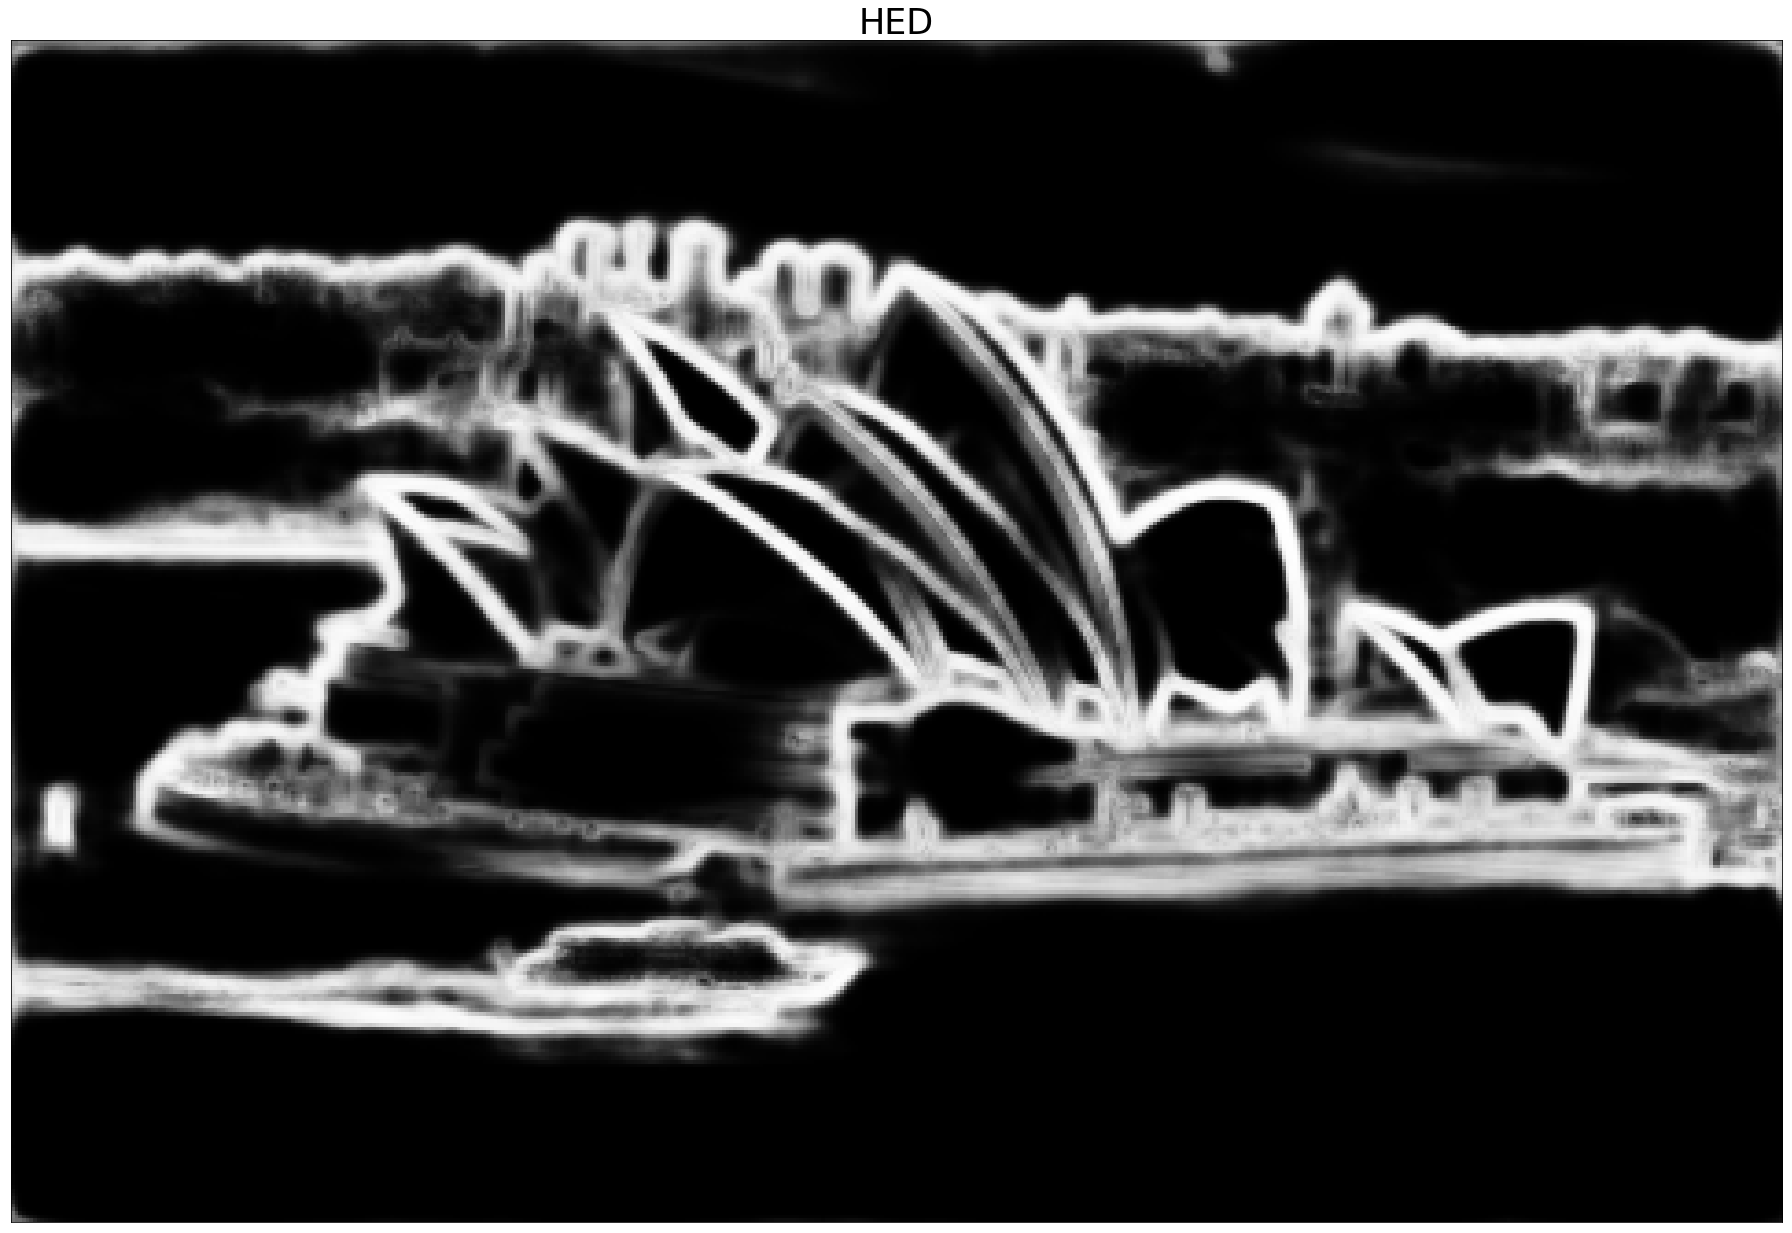

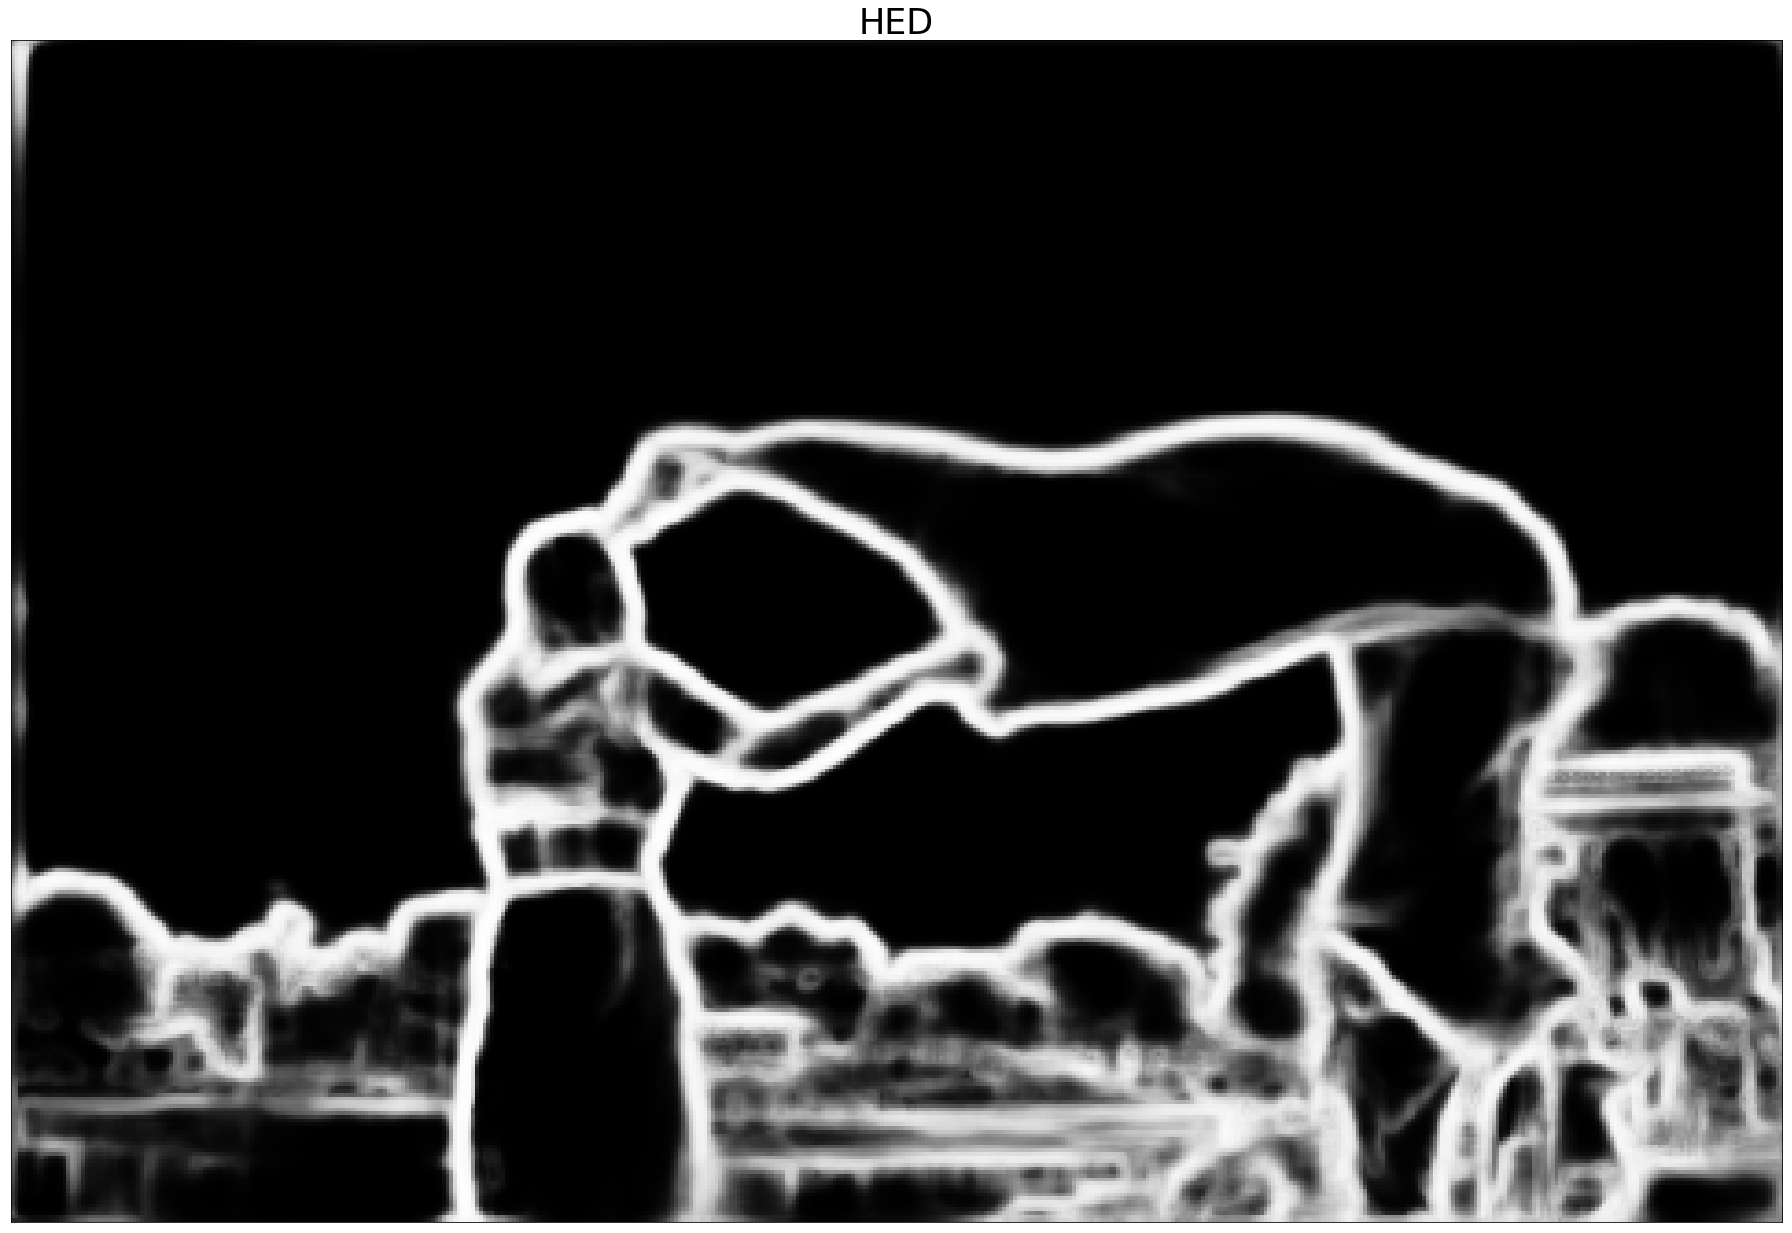

In [34]:
nVisualize = 10
for i, sample in enumerate(testDataloader):
    # get input sample image
    inp = sample
    inp = Variable(inp.cuda())
    
    # perform forward computation
    s1,s2,s3,s4,s5,s6 = net.forward(inp)
    
    # convert back to numpy arrays
    out = []
    out.append(grayTrans(s6.data.cpu()))
    #out.append(grayTrans(s1.data.cpu()))
    #out.append(grayTrans(s2.data.cpu()))
    #out.append(grayTrans(s3.data.cpu()))
    #out.append(grayTrans(s4.data.cpu()))

    #print(fname)
    img = Image.fromarray(out[0], 'L')
    #img.save(fname[0].split('.',1)[0]+'.png')

    # visualize every 10th image
    if i%nVisualize == 0:
        plotResults(out, 25)

In [36]:
np.shape(inp)

torch.Size([1, 3, 321, 481])